In [ ]:
import torch
import time
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
import numpy as np
from tqdm import tqdm
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch.optim as optim

REBUILD_DATA = True # set to true to one once, then back to false unless you want to change something in your training data.


In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('running on GPU')
else:
    device = torch.device('cpu')
    print('running on CPU')

running on GPU


In [ ]:
#@title Run this cell to download the dataset

from IPython import get_ipython
ipython = get_ipython()

def setup():
   ipython.magic("sx wget https://cdn.talentsprint.com/aiml/Experiment_related_data/Cat_Dog_data.zip")
   ipython.magic("sx unzip -qq Cat_Dog_data.zip")
   print ("Setup completed successfully")
   return

setup()

^C
Setup completed successfully


In [ ]:
class DogsVSCats():
    IMG_SIZE = 128
    CATS = "/content/Cat_Dog_data/train/cat"
    DOGS = "/content/Cat_Dog_data/train/dog"

    TESTING_CATS = "/content/Cat_Dog_data/test/cat"
    TESTING_DOGS = "/content/Cat_Dog_data/test/dog"

    LABELS = {CATS: 0, DOGS: 1}
    LABELS_TEST = {TESTING_CATS: 0, TESTING_DOGS: 1}

    training_data = []
    testing_data = []

    catcount = 0
    dogcount = 0

    catcount_test = 0
    dogcount_test = 0

    def make_training_data(self):
        for label in self.LABELS:
            #print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])  # do something like print(np.eye(2)[1]), just makes one_hot 
                        #print(np.eye(2)[self.LABELS[label]])

                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1

                    except Exception as e:
                        pass
                        #print(label, f, str(e))

        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print()
        print('Cats:',dogsvcats.catcount)
        print('Dogs:',dogsvcats.dogcount)
        print('------finish training set-----')


    def make_testing_data(self):
            for label_test in self.LABELS_TEST:
                #print(label)
                for f in tqdm(os.listdir(label_test)):
                    if "jpg" in f:
                        try:
                            path_test = os.path.join(label_test, f)
                            img = cv2.imread(path_test, cv2.IMREAD_GRAYSCALE)
                            img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                            self.testing_data.append([np.array(img), np.eye(2)[self.LABELS_TEST[label_test]]])  # do something like print(np.eye(2)[1]), just makes one_hot 
                            #print(np.eye(2)[self.LABELS[label]])

                            if label_test == self.TESTING_CATS:
                                self.catcount_test += 1
                            elif label_test == self.TESTING_DOGS:
                                self.dogcount_test += 1

                        except Exception as e:
                            pass
                            #print(label, f, str(e))

            #np.random.shuffle(self.testing_data)
            np.save("testing_data.npy", self.testing_data)
            print()
            print('Cats_test:',dogsvcats.catcount_test)
            print('Dogs_test:',dogsvcats.dogcount_test)

In [ ]:
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()
    dogsvcats.make_testing_data()


In [ ]:
training_data = np.load("training_data.npy", allow_pickle=True)
print('training data set length: ',len(training_data))

training data set length:  22500


In [ ]:
testing_data = np.load("testing_data.npy", allow_pickle=True)
print('testing data set length: ',len(testing_data))

testing data set length:  2500


In [ ]:
train_X = torch.Tensor([i[0] for i in training_data]).view(-1, 128, 128) # ToTensor
train_X = train_X/255.0 #Normalize

train_y = torch.Tensor([i[1] for i in training_data])

In [ ]:
test_X = torch.Tensor([i[0] for i in testing_data]).view(-1, 128, 128) # ToTensor
test_X = test_X/255.0 #Normalize

test_y = torch.Tensor([i[1] for i in testing_data])

VAL_PCT = 0.1
val_size = int(len(X) * VAL_PCT)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

#Look at training testing sizes

In [ ]:
print(len(train_X), len(train_y), 'train_X lenght, train_y lenght')
print(len(test_X), len(test_y), 'test_X lenght, test_y lenght')

22500 22500 train_X lenght, train_y lenght
2500 2500 test_X lenght, test_y lenght


#Build the model

In [ ]:
IMG_SIZE = 128

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.bn1 = nn.BatchNorm2d(32) 
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 conv
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 5)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 5)
        self.bn4 = nn.BatchNorm2d(256)

        x = torch.randn(IMG_SIZE,IMG_SIZE).view(-1,1,IMG_SIZE,IMG_SIZE) # 1 is the number of images in the input
        self._to_linear = None
        self.convs(x)


        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 216)
        self.fc3 = nn.Linear(216, 2)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv4(x)), (2,2))


        print(x[0].shape)
        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]

        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return F.softmax(x, dim=1) # 1 between cats and dogs while 0 between all batches


In [ ]:
net = Net().to(device) # move to GPU

torch.Size([256, 4, 4])


In [ ]:
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=216, bias=True)
  (fc3): Linear(in_features=216, out_features=2, bias=True)
)


#Improvement on code

##We definitely do not want to modify weights when we do our validation data, for example. For this reason, to default this to be False.

In [ ]:
def fwd_pass(X, y, train=False):
    if train:
        net.zero_grad()
    outputs = net(X)
    matches  = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)
    if train:
        loss.backward()
        optimizer.step()
    return acc, loss

#Eval method called in train method

In [ ]:
def test(size=32):
    X, y = test_X[:size], test_y[:size]
    val_acc, val_loss = fwd_pass(X.view(-1, 1, 128, 128).to(device), y.to(device))
    return val_acc, val_loss

In [ ]:
val_acc, val_loss = test(size=100)
print(val_acc, val_loss)

torch.Size([128, 4, 4])
0.89 tensor(0.0831, device='cuda:0', grad_fn=<MseLossBackward>)


#Initialization


In [ ]:
import time
BATCH_SIZE = 100
lr=0.001
EPOCHS = 25

MODEL_NAME = f"model-{int(time.time())}"  # gives a dynamic model name, to just help with things getting messy over time. 
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=lr)
loss_function = nn.MSELoss()

print(MODEL_NAME)


torch.Size([256, 4, 4])
model-1607572426


#Training and calling testing method

In [ ]:
def train(net):
    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,128,128).to(device)
                batch_y = train_y[i:i+BATCH_SIZE].to(device)
                acc, loss = fwd_pass(batch_X, batch_y, train=True)
                if i % 10 == 0:
                    val_acc, val_loss = test(size=100)
                    f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),2)},{round(float(loss), 4)},{round(float(val_acc),2)},{round(float(val_loss),4)},{epoch}\n") #{epoch}
            print(("\n Model observations:\n , Accuracy: {acc}  Loss: {loss}. " + 
            "Val_acc: {val_acc} val_loss: {val_loss}") \
            .format(acc=acc, loss=loss,val_acc=val_acc, val_loss=val_loss))

In [ ]:
train(net)


  0%|          | 1/225 [00:00<00:30,  7.26it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  1%|▏         | 3/225 [00:00<00:27,  8.15it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  2%|▏         | 4/225 [00:00<00:25,  8.61it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▎         | 8/225 [00:00<00:23,  9.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▍         | 10/225 [00:01<00:22,  9.70it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  5%|▌         | 12/225 [00:01<00:21,  9.89it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  6%|▌         | 14/225 [00:01<00:20, 10.05it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  8%|▊         | 18/225 [00:01<00:20, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  9%|▉         | 20/225 [00:01<00:19, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 10%|▉         | 22/225 [00:02<00:19, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 11%|█         | 24/225 [00:02<00:19, 10.26it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 12%|█▏        | 28/225 [00:02<00:19, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 13%|█▎        | 30/225 [00:02<00:19, 10.19it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 14%|█▍        | 32/225 [00:03<00:18, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 15%|█▌        | 34/225 [00:03<00:18, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 17%|█▋        | 38/225 [00:03<00:18, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 18%|█▊        | 40/225 [00:03<00:17, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 19%|█▊        | 42/225 [00:04<00:17, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 20%|█▉        | 44/225 [00:04<00:17, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 21%|██▏       | 48/225 [00:04<00:17, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 22%|██▏       | 50/225 [00:04<00:17, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 23%|██▎       | 52/225 [00:05<00:16, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 24%|██▍       | 54/225 [00:05<00:16, 10.28it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 26%|██▌       | 58/225 [00:05<00:16, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 27%|██▋       | 60/225 [00:05<00:16, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 62/225 [00:06<00:15, 10.28it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 64/225 [00:06<00:15, 10.26it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 30%|███       | 68/225 [00:06<00:15, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 31%|███       | 70/225 [00:06<00:15, 10.18it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 32%|███▏      | 72/225 [00:07<00:15, 10.13it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 33%|███▎      | 74/225 [00:07<00:14, 10.18it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 35%|███▍      | 78/225 [00:07<00:14, 10.14it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 36%|███▌      | 80/225 [00:07<00:14, 10.12it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 36%|███▋      | 82/225 [00:08<00:14, 10.11it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 37%|███▋      | 84/225 [00:08<00:13, 10.21it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 39%|███▉      | 88/225 [00:08<00:13, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 40%|████      | 90/225 [00:08<00:13, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 41%|████      | 92/225 [00:09<00:12, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 42%|████▏     | 94/225 [00:09<00:12, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 44%|████▎     | 98/225 [00:09<00:12, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 44%|████▍     | 100/225 [00:09<00:12, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 45%|████▌     | 102/225 [00:09<00:11, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 46%|████▌     | 104/225 [00:10<00:11, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 48%|████▊     | 108/225 [00:10<00:11, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 49%|████▉     | 110/225 [00:10<00:11, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 50%|████▉     | 112/225 [00:10<00:10, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 51%|█████     | 114/225 [00:11<00:10, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 52%|█████▏    | 118/225 [00:11<00:10, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 53%|█████▎    | 120/225 [00:11<00:10, 10.26it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 54%|█████▍    | 122/225 [00:11<00:10, 10.26it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 55%|█████▌    | 124/225 [00:12<00:09, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 57%|█████▋    | 128/225 [00:12<00:09, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 58%|█████▊    | 130/225 [00:12<00:09, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 59%|█████▊    | 132/225 [00:12<00:09, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 60%|█████▉    | 134/225 [00:13<00:08, 10.28it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 61%|██████▏   | 138/225 [00:13<00:08, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 62%|██████▏   | 140/225 [00:13<00:08, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 63%|██████▎   | 142/225 [00:13<00:08, 10.26it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 64%|██████▍   | 144/225 [00:14<00:07, 10.26it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 66%|██████▌   | 148/225 [00:14<00:07, 10.26it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 67%|██████▋   | 150/225 [00:14<00:07, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 152/225 [00:14<00:07, 10.24it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 154/225 [00:15<00:06, 10.26it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 70%|███████   | 158/225 [00:15<00:06, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 71%|███████   | 160/225 [00:15<00:06, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 72%|███████▏  | 162/225 [00:15<00:06, 10.28it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 73%|███████▎  | 164/225 [00:16<00:05, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 75%|███████▍  | 168/225 [00:16<00:05, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 76%|███████▌  | 170/225 [00:16<00:05, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 76%|███████▋  | 172/225 [00:16<00:05, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 77%|███████▋  | 174/225 [00:16<00:04, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 79%|███████▉  | 178/225 [00:17<00:04, 10.19it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 80%|████████  | 180/225 [00:17<00:04, 10.20it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 81%|████████  | 182/225 [00:17<00:04, 10.24it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 82%|████████▏ | 184/225 [00:17<00:04, 10.21it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 83%|████████▎ | 186/225 [00:18<00:03, 10.22it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 84%|████████▍ | 190/225 [00:18<00:03, 10.23it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 85%|████████▌ | 192/225 [00:18<00:03, 10.18it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 86%|████████▌ | 194/225 [00:18<00:03, 10.16it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 87%|████████▋ | 196/225 [00:19<00:02, 10.15it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 89%|████████▉ | 200/225 [00:19<00:02, 10.16it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 90%|████████▉ | 202/225 [00:19<00:02, 10.23it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 91%|█████████ | 204/225 [00:19<00:02, 10.24it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 92%|█████████▏| 206/225 [00:20<00:01, 10.28it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 93%|█████████▎| 210/225 [00:20<00:01, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 94%|█████████▍| 212/225 [00:20<00:01, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 95%|█████████▌| 214/225 [00:20<00:01, 10.28it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 96%|█████████▌| 216/225 [00:21<00:00, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 98%|█████████▊| 220/225 [00:21<00:00, 10.26it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 99%|█████████▊| 222/225 [00:21<00:00, 10.23it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



100%|██████████| 225/225 [00:21<00:00, 10.24it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])

 Model observations:
 , Accuracy: 0.63  Loss: 0.22855451703071594. Val_acc: 0.5 val_loss: 0.2853427529335022



  1%|          | 2/225 [00:00<00:21, 10.53it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  2%|▏         | 4/225 [00:00<00:21, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  3%|▎         | 6/225 [00:00<00:21, 10.06it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▍         | 9/225 [00:00<00:21, 10.01it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  5%|▍         | 11/225 [00:01<00:21,  9.96it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  6%|▌         | 13/225 [00:01<00:21,  9.92it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  7%|▋         | 15/225 [00:01<00:20, 10.03it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  8%|▊         | 17/225 [00:01<00:20, 10.15it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  9%|▉         | 21/225 [00:02<00:19, 10.22it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 10%|█         | 23/225 [00:02<00:19, 10.26it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 11%|█         | 25/225 [00:02<00:19, 10.28it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 12%|█▏        | 27/225 [00:02<00:19, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 14%|█▍        | 31/225 [00:03<00:19, 10.19it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 15%|█▍        | 33/225 [00:03<00:18, 10.21it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 16%|█▌        | 35/225 [00:03<00:18, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 16%|█▋        | 37/225 [00:03<00:18, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 18%|█▊        | 41/225 [00:04<00:17, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 19%|█▉        | 43/225 [00:04<00:17, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 20%|██        | 45/225 [00:04<00:17, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 21%|██        | 47/225 [00:04<00:17, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 23%|██▎       | 51/225 [00:05<00:17, 10.15it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 24%|██▎       | 53/225 [00:05<00:16, 10.14it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 24%|██▍       | 55/225 [00:05<00:16, 10.15it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 25%|██▌       | 57/225 [00:05<00:16, 10.10it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 27%|██▋       | 61/225 [00:05<00:16, 10.12it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 63/225 [00:06<00:15, 10.17it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 29%|██▉       | 65/225 [00:06<00:15, 10.21it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 30%|██▉       | 67/225 [00:06<00:15, 10.18it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 32%|███▏      | 71/225 [00:06<00:15, 10.20it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 32%|███▏      | 73/225 [00:07<00:14, 10.20it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 33%|███▎      | 75/225 [00:07<00:14, 10.24it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 34%|███▍      | 77/225 [00:07<00:14, 10.26it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 36%|███▌      | 81/225 [00:07<00:13, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 37%|███▋      | 83/225 [00:08<00:13, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 38%|███▊      | 85/225 [00:08<00:13, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 39%|███▊      | 87/225 [00:08<00:13, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 40%|████      | 91/225 [00:08<00:12, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 41%|████▏     | 93/225 [00:09<00:12, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 42%|████▏     | 95/225 [00:09<00:12, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 43%|████▎     | 97/225 [00:09<00:12, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 45%|████▍     | 101/225 [00:09<00:11, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 46%|████▌     | 103/225 [00:10<00:11, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 47%|████▋     | 105/225 [00:10<00:11, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 48%|████▊     | 107/225 [00:10<00:11, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 49%|████▉     | 111/225 [00:10<00:10, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 50%|█████     | 113/225 [00:11<00:10, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 51%|█████     | 115/225 [00:11<00:10, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 52%|█████▏    | 117/225 [00:11<00:10, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 54%|█████▍    | 121/225 [00:11<00:10, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 55%|█████▍    | 123/225 [00:11<00:09, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 56%|█████▌    | 125/225 [00:12<00:09, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 56%|█████▋    | 127/225 [00:12<00:09, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 58%|█████▊    | 131/225 [00:12<00:08, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 59%|█████▉    | 133/225 [00:12<00:08, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 60%|██████    | 135/225 [00:13<00:08, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 61%|██████    | 137/225 [00:13<00:08, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 63%|██████▎   | 141/225 [00:13<00:07, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 64%|██████▎   | 143/225 [00:13<00:07, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 64%|██████▍   | 145/225 [00:14<00:07, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 65%|██████▌   | 147/225 [00:14<00:07, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 67%|██████▋   | 151/225 [00:14<00:07, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 153/225 [00:14<00:06, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 69%|██████▉   | 155/225 [00:15<00:06, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 70%|██████▉   | 157/225 [00:15<00:06, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 72%|███████▏  | 161/225 [00:15<00:06, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 72%|███████▏  | 163/225 [00:15<00:05, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 73%|███████▎  | 165/225 [00:15<00:05, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 74%|███████▍  | 167/225 [00:16<00:05, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 76%|███████▌  | 171/225 [00:16<00:05, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 77%|███████▋  | 173/225 [00:16<00:05, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 78%|███████▊  | 175/225 [00:16<00:04, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 79%|███████▊  | 177/225 [00:17<00:04, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 80%|████████  | 181/225 [00:17<00:04, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 81%|████████▏ | 183/225 [00:17<00:04, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 82%|████████▏ | 185/225 [00:17<00:03, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 83%|████████▎ | 187/225 [00:18<00:03, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 85%|████████▍ | 191/225 [00:18<00:03, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 86%|████████▌ | 193/225 [00:18<00:03, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 87%|████████▋ | 195/225 [00:18<00:02, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 88%|████████▊ | 197/225 [00:19<00:02, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 89%|████████▉ | 201/225 [00:19<00:02, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 90%|█████████ | 203/225 [00:19<00:02, 10.54it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 91%|█████████ | 205/225 [00:19<00:01, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 92%|█████████▏| 207/225 [00:19<00:01, 10.53it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 94%|█████████▍| 211/225 [00:20<00:01, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 95%|█████████▍| 213/225 [00:20<00:01, 10.52it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 96%|█████████▌| 215/225 [00:20<00:00, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 96%|█████████▋| 217/225 [00:20<00:00, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 98%|█████████▊| 221/225 [00:21<00:00, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 99%|█████████▉| 223/225 [00:21<00:00, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



100%|██████████| 225/225 [00:21<00:00, 10.36it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])

 Model observations:
 , Accuracy: 0.76  Loss: 0.1569957286119461. Val_acc: 0.69 val_loss: 0.1843559294939041
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  1%|          | 2/225 [00:00<00:20, 10.66it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  3%|▎         | 6/225 [00:00<00:20, 10.61it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▎         | 8/225 [00:00<00:20, 10.56it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▍         | 10/225 [00:00<00:20, 10.54it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  5%|▌         | 12/225 [00:01<00:20, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  7%|▋         | 16/225 [00:01<00:19, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  8%|▊         | 18/225 [00:01<00:19, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  9%|▉         | 20/225 [00:01<00:19, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 10%|▉         | 22/225 [00:02<00:19, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 12%|█▏        | 26/225 [00:02<00:19, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 12%|█▏        | 28/225 [00:02<00:18, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 13%|█▎        | 30/225 [00:02<00:18, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 14%|█▍        | 32/225 [00:03<00:18, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 16%|█▌        | 36/225 [00:03<00:18, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 17%|█▋        | 38/225 [00:03<00:17, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 18%|█▊        | 40/225 [00:03<00:17, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 19%|█▊        | 42/225 [00:04<00:17, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 20%|██        | 46/225 [00:04<00:16, 10.53it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 21%|██▏       | 48/225 [00:04<00:16, 10.54it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 22%|██▏       | 50/225 [00:04<00:16, 10.54it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 23%|██▎       | 52/225 [00:04<00:16, 10.53it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 25%|██▍       | 56/225 [00:05<00:16, 10.55it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 26%|██▌       | 58/225 [00:05<00:15, 10.55it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 27%|██▋       | 60/225 [00:05<00:15, 10.56it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 62/225 [00:05<00:15, 10.54it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 29%|██▉       | 66/225 [00:06<00:15, 10.55it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 30%|███       | 68/225 [00:06<00:14, 10.52it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 31%|███       | 70/225 [00:06<00:14, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 32%|███▏      | 72/225 [00:06<00:14, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 34%|███▍      | 76/225 [00:07<00:14, 10.55it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 35%|███▍      | 78/225 [00:07<00:13, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 36%|███▌      | 80/225 [00:07<00:13, 10.52it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 36%|███▋      | 82/225 [00:07<00:13, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 38%|███▊      | 86/225 [00:08<00:13, 10.56it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 39%|███▉      | 88/225 [00:08<00:12, 10.54it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 40%|████      | 90/225 [00:08<00:12, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 41%|████      | 92/225 [00:08<00:12, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 43%|████▎     | 96/225 [00:09<00:12, 10.54it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 44%|████▎     | 98/225 [00:09<00:12, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 44%|████▍     | 100/225 [00:09<00:11, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 45%|████▌     | 102/225 [00:09<00:11, 10.53it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 47%|████▋     | 106/225 [00:10<00:11, 10.52it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 48%|████▊     | 108/225 [00:10<00:11, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 49%|████▉     | 110/225 [00:10<00:10, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 50%|████▉     | 112/225 [00:10<00:10, 10.54it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 52%|█████▏    | 116/225 [00:11<00:10, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 52%|█████▏    | 118/225 [00:11<00:10, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 53%|█████▎    | 120/225 [00:11<00:10, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 54%|█████▍    | 122/225 [00:11<00:09, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 56%|█████▌    | 126/225 [00:11<00:09, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 57%|█████▋    | 128/225 [00:12<00:09, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 58%|█████▊    | 130/225 [00:12<00:09, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 59%|█████▊    | 132/225 [00:12<00:08, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 60%|██████    | 136/225 [00:12<00:08, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 61%|██████▏   | 138/225 [00:13<00:08, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 62%|██████▏   | 140/225 [00:13<00:08, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 63%|██████▎   | 142/225 [00:13<00:07, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 65%|██████▍   | 146/225 [00:13<00:07, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 66%|██████▌   | 148/225 [00:14<00:07, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 67%|██████▋   | 150/225 [00:14<00:07, 10.20it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 152/225 [00:14<00:07, 10.21it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 154/225 [00:14<00:06, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 70%|███████   | 158/225 [00:15<00:06, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 71%|███████   | 160/225 [00:15<00:06, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 72%|███████▏  | 162/225 [00:15<00:06, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 73%|███████▎  | 164/225 [00:15<00:05, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 75%|███████▍  | 168/225 [00:16<00:05, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 76%|███████▌  | 170/225 [00:16<00:05, 10.52it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 76%|███████▋  | 172/225 [00:16<00:05, 10.56it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 77%|███████▋  | 174/225 [00:16<00:04, 10.58it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 79%|███████▉  | 178/225 [00:16<00:04, 10.60it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 80%|████████  | 180/225 [00:17<00:04, 10.60it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 81%|████████  | 182/225 [00:17<00:04, 10.62it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 82%|████████▏ | 184/225 [00:17<00:03, 10.59it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 84%|████████▎ | 188/225 [00:17<00:03, 10.62it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 84%|████████▍ | 190/225 [00:18<00:03, 10.60it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 85%|████████▌ | 192/225 [00:18<00:03, 10.57it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 86%|████████▌ | 194/225 [00:18<00:02, 10.58it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 88%|████████▊ | 198/225 [00:18<00:02, 10.55it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 89%|████████▉ | 200/225 [00:19<00:02, 10.54it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 90%|████████▉ | 202/225 [00:19<00:02, 10.57it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 91%|█████████ | 204/225 [00:19<00:01, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 92%|█████████▏| 208/225 [00:19<00:01, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 93%|█████████▎| 210/225 [00:20<00:01, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 94%|█████████▍| 212/225 [00:20<00:01, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 95%|█████████▌| 214/225 [00:20<00:01, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 97%|█████████▋| 218/225 [00:20<00:00, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 98%|█████████▊| 220/225 [00:20<00:00, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 99%|█████████▊| 222/225 [00:21<00:00, 10.55it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



100%|██████████| 225/225 [00:21<00:00, 10.49it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])

 Model observations:
 , Accuracy: 0.8  Loss: 0.12185519188642502. Val_acc: 0.85 val_loss: 0.11812509596347809
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  1%|▏         | 3/225 [00:00<00:21, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  2%|▏         | 4/225 [00:00<00:21, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  3%|▎         | 6/225 [00:00<00:21, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▍         | 10/225 [00:00<00:20, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  5%|▌         | 12/225 [00:01<00:20, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  6%|▌         | 14/225 [00:01<00:20, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  7%|▋         | 16/225 [00:01<00:20, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  9%|▉         | 20/225 [00:01<00:19, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 10%|▉         | 22/225 [00:02<00:19, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 11%|█         | 24/225 [00:02<00:19, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 12%|█▏        | 26/225 [00:02<00:19, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 13%|█▎        | 30/225 [00:02<00:18, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 14%|█▍        | 32/225 [00:03<00:18, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 15%|█▌        | 34/225 [00:03<00:18, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 16%|█▌        | 36/225 [00:03<00:18, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 18%|█▊        | 40/225 [00:03<00:17, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 19%|█▊        | 42/225 [00:04<00:17, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 20%|█▉        | 44/225 [00:04<00:17, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 20%|██        | 46/225 [00:04<00:17, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 22%|██▏       | 50/225 [00:04<00:16, 10.52it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 23%|██▎       | 52/225 [00:04<00:16, 10.55it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 24%|██▍       | 54/225 [00:05<00:16, 10.56it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 25%|██▍       | 56/225 [00:05<00:16, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 27%|██▋       | 60/225 [00:05<00:15, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 62/225 [00:05<00:15, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 64/225 [00:06<00:15, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 29%|██▉       | 66/225 [00:06<00:15, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 31%|███       | 70/225 [00:06<00:15, 10.26it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 32%|███▏      | 72/225 [00:06<00:14, 10.23it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 33%|███▎      | 74/225 [00:07<00:14, 10.28it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 34%|███▍      | 76/225 [00:07<00:14, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 36%|███▌      | 80/225 [00:07<00:14, 10.20it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 36%|███▋      | 82/225 [00:07<00:13, 10.24it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 37%|███▋      | 84/225 [00:08<00:13, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 38%|███▊      | 86/225 [00:08<00:13, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 40%|████      | 90/225 [00:08<00:13, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 41%|████      | 92/225 [00:08<00:12, 10.26it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 42%|████▏     | 94/225 [00:09<00:12, 10.19it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 43%|████▎     | 96/225 [00:09<00:12, 10.18it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 44%|████▍     | 100/225 [00:09<00:12, 10.28it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 45%|████▌     | 102/225 [00:09<00:11, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 46%|████▌     | 104/225 [00:10<00:11, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 47%|████▋     | 106/225 [00:10<00:11, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 49%|████▉     | 110/225 [00:10<00:11, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 50%|████▉     | 112/225 [00:10<00:10, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 51%|█████     | 114/225 [00:11<00:10, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 52%|█████▏    | 116/225 [00:11<00:10, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 53%|█████▎    | 120/225 [00:11<00:10, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 54%|█████▍    | 122/225 [00:11<00:09, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 55%|█████▌    | 124/225 [00:11<00:09, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 56%|█████▌    | 126/225 [00:12<00:09, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 58%|█████▊    | 130/225 [00:12<00:09, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 59%|█████▊    | 132/225 [00:12<00:09, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 60%|█████▉    | 134/225 [00:12<00:08, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 60%|██████    | 136/225 [00:13<00:08, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 62%|██████▏   | 140/225 [00:13<00:08, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 63%|██████▎   | 142/225 [00:13<00:08, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 64%|██████▍   | 144/225 [00:13<00:07, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 65%|██████▍   | 146/225 [00:14<00:07, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 67%|██████▋   | 150/225 [00:14<00:07, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 152/225 [00:14<00:06, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 154/225 [00:14<00:06, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 69%|██████▉   | 156/225 [00:15<00:06, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 71%|███████   | 160/225 [00:15<00:06, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 72%|███████▏  | 162/225 [00:15<00:06, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 73%|███████▎  | 164/225 [00:15<00:05, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 74%|███████▍  | 166/225 [00:16<00:05, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 76%|███████▌  | 170/225 [00:16<00:05, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 76%|███████▋  | 172/225 [00:16<00:05, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 77%|███████▋  | 174/225 [00:16<00:04, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 78%|███████▊  | 176/225 [00:16<00:04, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 80%|████████  | 180/225 [00:17<00:04, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 81%|████████  | 182/225 [00:17<00:04, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 82%|████████▏ | 184/225 [00:17<00:03, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 83%|████████▎ | 186/225 [00:17<00:03, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 84%|████████▍ | 190/225 [00:18<00:03, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 85%|████████▌ | 192/225 [00:18<00:03, 10.28it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 86%|████████▌ | 194/225 [00:18<00:03, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 87%|████████▋ | 196/225 [00:18<00:02, 10.23it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 89%|████████▉ | 200/225 [00:19<00:02, 10.24it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 90%|████████▉ | 202/225 [00:19<00:02, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 91%|█████████ | 204/225 [00:19<00:02, 10.28it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 92%|█████████▏| 206/225 [00:19<00:01, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 93%|█████████▎| 210/225 [00:20<00:01, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 94%|█████████▍| 212/225 [00:20<00:01, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 95%|█████████▌| 214/225 [00:20<00:01, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 96%|█████████▌| 216/225 [00:20<00:00, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 98%|█████████▊| 220/225 [00:21<00:00, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 99%|█████████▊| 222/225 [00:21<00:00, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



100%|██████████| 225/225 [00:21<00:00, 10.35it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])

 Model observations:
 , Accuracy: 0.86  Loss: 0.10678960382938385. Val_acc: 0.9 val_loss: 0.07845708727836609



  1%|          | 2/225 [00:00<00:21, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  2%|▏         | 4/225 [00:00<00:21, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  3%|▎         | 6/225 [00:00<00:20, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▎         | 8/225 [00:00<00:20, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  5%|▌         | 12/225 [00:01<00:20, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  6%|▌         | 14/225 [00:01<00:20, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  7%|▋         | 16/225 [00:01<00:20, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  8%|▊         | 18/225 [00:01<00:19, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 10%|▉         | 22/225 [00:02<00:19, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 11%|█         | 24/225 [00:02<00:19, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 12%|█▏        | 26/225 [00:02<00:19, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 12%|█▏        | 28/225 [00:02<00:19, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 14%|█▍        | 32/225 [00:03<00:18, 10.26it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 15%|█▌        | 34/225 [00:03<00:18, 10.22it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 16%|█▌        | 36/225 [00:03<00:18, 10.21it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 17%|█▋        | 38/225 [00:03<00:18, 10.24it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 19%|█▊        | 42/225 [00:04<00:17, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 20%|█▉        | 44/225 [00:04<00:17, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 20%|██        | 46/225 [00:04<00:17, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 21%|██▏       | 48/225 [00:04<00:17, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 23%|██▎       | 52/225 [00:05<00:16, 10.26it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 24%|██▍       | 54/225 [00:05<00:16, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 25%|██▍       | 56/225 [00:05<00:16, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 26%|██▌       | 58/225 [00:05<00:16, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 62/225 [00:05<00:15, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 64/225 [00:06<00:15, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 29%|██▉       | 66/225 [00:06<00:15, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 30%|███       | 68/225 [00:06<00:15, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 32%|███▏      | 72/225 [00:06<00:14, 10.28it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 33%|███▎      | 74/225 [00:07<00:14, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 34%|███▍      | 76/225 [00:07<00:14, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 35%|███▍      | 78/225 [00:07<00:14, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 36%|███▋      | 82/225 [00:07<00:13, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 37%|███▋      | 84/225 [00:08<00:13, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 38%|███▊      | 86/225 [00:08<00:13, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 39%|███▉      | 88/225 [00:08<00:13, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 41%|████      | 92/225 [00:08<00:12, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 42%|████▏     | 94/225 [00:09<00:12, 10.28it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 43%|████▎     | 96/225 [00:09<00:12, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 44%|████▎     | 98/225 [00:09<00:12, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 45%|████▌     | 102/225 [00:09<00:12, 10.24it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 46%|████▌     | 104/225 [00:10<00:11, 10.21it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 47%|████▋     | 106/225 [00:10<00:11, 10.17it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 48%|████▊     | 108/225 [00:10<00:11, 10.17it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 50%|████▉     | 112/225 [00:10<00:11, 10.16it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 51%|█████     | 114/225 [00:11<00:10, 10.21it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 52%|█████▏    | 116/225 [00:11<00:10, 10.20it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 52%|█████▏    | 118/225 [00:11<00:10, 10.21it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 54%|█████▍    | 122/225 [00:11<00:10, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 55%|█████▌    | 124/225 [00:12<00:09, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 56%|█████▌    | 126/225 [00:12<00:09, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 57%|█████▋    | 128/225 [00:12<00:09, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 59%|█████▊    | 132/225 [00:12<00:08, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 60%|█████▉    | 134/225 [00:12<00:08, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 60%|██████    | 136/225 [00:13<00:08, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 61%|██████▏   | 138/225 [00:13<00:08, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 63%|██████▎   | 142/225 [00:13<00:08, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 64%|██████▍   | 144/225 [00:13<00:07, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 65%|██████▍   | 146/225 [00:14<00:07, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 66%|██████▌   | 148/225 [00:14<00:07, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 152/225 [00:14<00:07, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 154/225 [00:14<00:06, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 69%|██████▉   | 156/225 [00:15<00:06, 10.28it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 70%|███████   | 158/225 [00:15<00:06, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 72%|███████▏  | 162/225 [00:15<00:06, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 73%|███████▎  | 164/225 [00:15<00:05, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 74%|███████▍  | 166/225 [00:16<00:05, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 75%|███████▍  | 168/225 [00:16<00:05, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 76%|███████▋  | 172/225 [00:16<00:05, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 77%|███████▋  | 174/225 [00:16<00:04, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 78%|███████▊  | 176/225 [00:17<00:04, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 79%|███████▉  | 178/225 [00:17<00:04, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 81%|████████  | 182/225 [00:17<00:04, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 82%|████████▏ | 184/225 [00:17<00:03, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 83%|████████▎ | 186/225 [00:18<00:03, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 84%|████████▎ | 188/225 [00:18<00:03, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 85%|████████▌ | 192/225 [00:18<00:03, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 86%|████████▌ | 194/225 [00:18<00:02, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 87%|████████▋ | 196/225 [00:18<00:02, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 88%|████████▊ | 198/225 [00:19<00:02, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 90%|████████▉ | 202/225 [00:19<00:02, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 91%|█████████ | 204/225 [00:19<00:02, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 92%|█████████▏| 206/225 [00:19<00:01, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 92%|█████████▏| 208/225 [00:20<00:01, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 94%|█████████▍| 212/225 [00:20<00:01, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 95%|█████████▌| 214/225 [00:20<00:01, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 96%|█████████▌| 216/225 [00:20<00:00, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 97%|█████████▋| 218/225 [00:21<00:00, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 99%|█████████▊| 222/225 [00:21<00:00, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



100%|█████████▉| 224/225 [00:21<00:00, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])


100%|██████████| 225/225 [00:21<00:00, 10.33it/s]

  1%|          | 2/225 [00:00<00:21, 10.55it/s]


 Model observations:
 , Accuracy: 0.9  Loss: 0.07907748967409134. Val_acc: 0.9 val_loss: 0.0719737783074379
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  2%|▏         | 4/225 [00:00<00:20, 10.54it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  3%|▎         | 7/225 [00:00<00:21, 10.21it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▍         | 9/225 [00:00<00:21,  9.94it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▍         | 10/225 [00:00<00:21,  9.92it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  6%|▌         | 13/225 [00:01<00:21,  9.94it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  7%|▋         | 15/225 [00:01<00:20, 10.09it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  8%|▊         | 19/225 [00:01<00:20, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  9%|▉         | 21/225 [00:02<00:19, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 10%|█         | 23/225 [00:02<00:19, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 11%|█         | 25/225 [00:02<00:19, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 13%|█▎        | 29/225 [00:02<00:18, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 14%|█▍        | 31/225 [00:03<00:18, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 15%|█▍        | 33/225 [00:03<00:18, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 16%|█▌        | 35/225 [00:03<00:18, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 17%|█▋        | 39/225 [00:03<00:17, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 18%|█▊        | 41/225 [00:03<00:17, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 19%|█▉        | 43/225 [00:04<00:17, 10.28it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 20%|██        | 45/225 [00:04<00:17, 10.28it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 22%|██▏       | 49/225 [00:04<00:17, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 23%|██▎       | 51/225 [00:04<00:16, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 24%|██▎       | 53/225 [00:05<00:16, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 24%|██▍       | 55/225 [00:05<00:16, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 26%|██▌       | 59/225 [00:05<00:16, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 27%|██▋       | 61/225 [00:05<00:15, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 63/225 [00:06<00:15, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 29%|██▉       | 65/225 [00:06<00:15, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 31%|███       | 69/225 [00:06<00:15, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 32%|███▏      | 71/225 [00:06<00:14, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 32%|███▏      | 73/225 [00:07<00:14, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 33%|███▎      | 75/225 [00:07<00:14, 10.24it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 35%|███▌      | 79/225 [00:07<00:14, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 36%|███▌      | 81/225 [00:07<00:13, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 37%|███▋      | 83/225 [00:08<00:13, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 38%|███▊      | 85/225 [00:08<00:13, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 40%|███▉      | 89/225 [00:08<00:13, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 40%|████      | 91/225 [00:08<00:12, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 41%|████▏     | 93/225 [00:09<00:12, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 42%|████▏     | 95/225 [00:09<00:12, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 44%|████▍     | 99/225 [00:09<00:12, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 45%|████▍     | 101/225 [00:09<00:11, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 46%|████▌     | 103/225 [00:09<00:11, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 47%|████▋     | 105/225 [00:10<00:11, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 48%|████▊     | 109/225 [00:10<00:11, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 49%|████▉     | 111/225 [00:10<00:10, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 50%|█████     | 113/225 [00:10<00:10, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 51%|█████     | 115/225 [00:11<00:10, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 53%|█████▎    | 119/225 [00:11<00:10, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 54%|█████▍    | 121/225 [00:11<00:09, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 55%|█████▍    | 123/225 [00:11<00:09, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 56%|█████▌    | 125/225 [00:12<00:09, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 57%|█████▋    | 129/225 [00:12<00:09, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 58%|█████▊    | 131/225 [00:12<00:09, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 59%|█████▉    | 133/225 [00:12<00:08, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 60%|██████    | 135/225 [00:13<00:08, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 62%|██████▏   | 139/225 [00:13<00:08, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 63%|██████▎   | 141/225 [00:13<00:08, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 64%|██████▎   | 143/225 [00:13<00:07, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 64%|██████▍   | 145/225 [00:14<00:07, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 66%|██████▌   | 149/225 [00:14<00:07, 10.26it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 67%|██████▋   | 151/225 [00:14<00:07, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 153/225 [00:14<00:06, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 69%|██████▉   | 155/225 [00:14<00:06, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 71%|███████   | 159/225 [00:15<00:06, 10.22it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 72%|███████▏  | 161/225 [00:15<00:06, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 72%|███████▏  | 163/225 [00:15<00:06, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 73%|███████▎  | 165/225 [00:15<00:05, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 75%|███████▌  | 169/225 [00:16<00:05, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 76%|███████▌  | 171/225 [00:16<00:05, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 77%|███████▋  | 173/225 [00:16<00:04, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 78%|███████▊  | 175/225 [00:16<00:04, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 80%|███████▉  | 179/225 [00:17<00:04, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 80%|████████  | 181/225 [00:17<00:04, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 81%|████████▏ | 183/225 [00:17<00:04, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 82%|████████▏ | 185/225 [00:17<00:03, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 84%|████████▍ | 189/225 [00:18<00:03, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 85%|████████▍ | 191/225 [00:18<00:03, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 86%|████████▌ | 193/225 [00:18<00:03, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 87%|████████▋ | 195/225 [00:18<00:02, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 88%|████████▊ | 199/225 [00:19<00:02, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 89%|████████▉ | 201/225 [00:19<00:02, 10.26it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 90%|█████████ | 203/225 [00:19<00:02, 10.28it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 91%|█████████ | 205/225 [00:19<00:01, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 93%|█████████▎| 209/225 [00:20<00:01, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 94%|█████████▍| 211/225 [00:20<00:01, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 95%|█████████▍| 213/225 [00:20<00:01, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 96%|█████████▌| 215/225 [00:20<00:00, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 97%|█████████▋| 219/225 [00:21<00:00, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 98%|█████████▊| 221/225 [00:21<00:00, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 99%|█████████▉| 223/225 [00:21<00:00, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



100%|██████████| 225/225 [00:21<00:00, 10.36it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([256, 4, 4])

 Model observations:
 , Accuracy: 0.91  Loss: 0.06502874940633774. Val_acc: 0.86 val_loss: 0.0873987004160881
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  2%|▏         | 4/225 [00:00<00:20, 10.55it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  3%|▎         | 6/225 [00:00<00:20, 10.53it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▎         | 8/225 [00:00<00:20, 10.53it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▍         | 10/225 [00:00<00:20, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  6%|▌         | 14/225 [00:01<00:20, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  7%|▋         | 16/225 [00:01<00:20, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  8%|▊         | 19/225 [00:01<00:20, 10.18it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  9%|▉         | 20/225 [00:01<00:20, 10.10it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 10%|▉         | 22/225 [00:02<00:20, 10.15it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 12%|█▏        | 26/225 [00:02<00:19, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 12%|█▏        | 28/225 [00:02<00:18, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 13%|█▎        | 30/225 [00:02<00:18, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 14%|█▍        | 32/225 [00:03<00:18, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 16%|█▌        | 36/225 [00:03<00:18, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 17%|█▋        | 38/225 [00:03<00:17, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 18%|█▊        | 40/225 [00:03<00:17, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 19%|█▊        | 42/225 [00:04<00:17, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 20%|██        | 46/225 [00:04<00:17, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 21%|██▏       | 48/225 [00:04<00:16, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 22%|██▏       | 50/225 [00:04<00:16, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 23%|██▎       | 52/225 [00:04<00:16, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 25%|██▍       | 56/225 [00:05<00:16, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 26%|██▌       | 58/225 [00:05<00:15, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 27%|██▋       | 60/225 [00:05<00:15, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 62/225 [00:05<00:15, 10.24it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 64/225 [00:06<00:15, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 30%|███       | 68/225 [00:06<00:15, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 31%|███       | 70/225 [00:06<00:14, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 32%|███▏      | 72/225 [00:06<00:14, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 33%|███▎      | 74/225 [00:07<00:14, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 35%|███▍      | 78/225 [00:07<00:14, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 36%|███▌      | 80/225 [00:07<00:13, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 36%|███▋      | 82/225 [00:07<00:13, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 37%|███▋      | 84/225 [00:08<00:13, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 39%|███▉      | 88/225 [00:08<00:13, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 40%|████      | 90/225 [00:08<00:12, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 41%|████      | 92/225 [00:08<00:12, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 42%|████▏     | 94/225 [00:09<00:12, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 44%|████▎     | 98/225 [00:09<00:12, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 44%|████▍     | 100/225 [00:09<00:12, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 45%|████▌     | 102/225 [00:09<00:11, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 46%|████▌     | 104/225 [00:10<00:11, 10.26it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 48%|████▊     | 108/225 [00:10<00:11, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 49%|████▉     | 110/225 [00:10<00:11, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 50%|████▉     | 112/225 [00:10<00:10, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 51%|█████     | 114/225 [00:10<00:10, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 52%|█████▏    | 118/225 [00:11<00:10, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 53%|█████▎    | 120/225 [00:11<00:10, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 54%|█████▍    | 122/225 [00:11<00:09, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 55%|█████▌    | 124/225 [00:11<00:09, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 57%|█████▋    | 128/225 [00:12<00:09, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 58%|█████▊    | 130/225 [00:12<00:09, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 59%|█████▊    | 132/225 [00:12<00:08, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 60%|█████▉    | 134/225 [00:12<00:08, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 61%|██████▏   | 138/225 [00:13<00:08, 10.24it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 62%|██████▏   | 140/225 [00:13<00:08, 10.21it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 63%|██████▎   | 142/225 [00:13<00:08, 10.19it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 64%|██████▍   | 144/225 [00:13<00:07, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 66%|██████▌   | 148/225 [00:14<00:07, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 67%|██████▋   | 150/225 [00:14<00:07, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 152/225 [00:14<00:07, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 154/225 [00:14<00:06, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 70%|███████   | 158/225 [00:15<00:06, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 71%|███████   | 160/225 [00:15<00:06, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 72%|███████▏  | 162/225 [00:15<00:06, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 73%|███████▎  | 164/225 [00:15<00:05, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 75%|███████▍  | 168/225 [00:16<00:05, 10.52it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 76%|███████▌  | 170/225 [00:16<00:05, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 76%|███████▋  | 172/225 [00:16<00:05, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 77%|███████▋  | 174/225 [00:16<00:04, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 79%|███████▉  | 178/225 [00:17<00:04, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 80%|████████  | 180/225 [00:17<00:04, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 81%|████████  | 182/225 [00:17<00:04, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 82%|████████▏ | 184/225 [00:17<00:04, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 83%|████████▎ | 186/225 [00:17<00:03, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 84%|████████▍ | 190/225 [00:18<00:03, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 85%|████████▌ | 192/225 [00:18<00:03, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 86%|████████▌ | 194/225 [00:18<00:02, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 87%|████████▋ | 196/225 [00:18<00:02, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 89%|████████▉ | 200/225 [00:19<00:02, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 90%|████████▉ | 202/225 [00:19<00:02, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 91%|█████████ | 204/225 [00:19<00:02, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 92%|█████████▏| 206/225 [00:19<00:01, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 93%|█████████▎| 210/225 [00:20<00:01, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 94%|█████████▍| 212/225 [00:20<00:01, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 95%|█████████▌| 214/225 [00:20<00:01, 10.28it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 96%|█████████▌| 216/225 [00:20<00:00, 10.26it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 98%|█████████▊| 220/225 [00:21<00:00, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 99%|█████████▊| 222/225 [00:21<00:00, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



100%|██████████| 225/225 [00:21<00:00, 10.39it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])

 Model observations:
 , Accuracy: 0.92  Loss: 0.05538588762283325. Val_acc: 0.86 val_loss: 0.09619542956352234



  1%|          | 2/225 [00:00<00:20, 10.66it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  2%|▏         | 4/225 [00:00<00:21, 10.24it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  3%|▎         | 7/225 [00:00<00:21,  9.95it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▍         | 9/225 [00:00<00:21,  9.87it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  5%|▍         | 11/225 [00:01<00:21,  9.99it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  6%|▌         | 13/225 [00:01<00:20, 10.11it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  6%|▌         | 14/225 [00:01<00:21,  9.85it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  8%|▊         | 18/225 [00:01<00:20, 10.15it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  9%|▉         | 20/225 [00:01<00:20, 10.24it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 10%|▉         | 22/225 [00:02<00:19, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 11%|█         | 24/225 [00:02<00:19, 10.23it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 12%|█▏        | 28/225 [00:02<00:19, 10.17it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 13%|█▎        | 30/225 [00:02<00:19, 10.17it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 14%|█▍        | 32/225 [00:03<00:18, 10.24it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 15%|█▌        | 34/225 [00:03<00:18, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 17%|█▋        | 38/225 [00:03<00:17, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 18%|█▊        | 40/225 [00:03<00:17, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 19%|█▊        | 42/225 [00:04<00:17, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 20%|█▉        | 44/225 [00:04<00:17, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 21%|██▏       | 48/225 [00:04<00:17, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 22%|██▏       | 50/225 [00:04<00:16, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 23%|██▎       | 52/225 [00:05<00:16, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 24%|██▍       | 54/225 [00:05<00:16, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 26%|██▌       | 58/225 [00:05<00:16, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 27%|██▋       | 60/225 [00:05<00:15, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 62/225 [00:06<00:15, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 64/225 [00:06<00:15, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 30%|███       | 68/225 [00:06<00:15, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 31%|███       | 70/225 [00:06<00:15, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 32%|███▏      | 72/225 [00:06<00:14, 10.23it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 33%|███▎      | 74/225 [00:07<00:14, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 35%|███▍      | 78/225 [00:07<00:14, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 36%|███▌      | 80/225 [00:07<00:14, 10.05it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 36%|███▋      | 82/225 [00:07<00:13, 10.22it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 37%|███▋      | 84/225 [00:08<00:13, 10.28it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 38%|███▊      | 86/225 [00:08<00:13, 10.28it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 40%|████      | 90/225 [00:08<00:13, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 41%|████      | 92/225 [00:08<00:12, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 42%|████▏     | 94/225 [00:09<00:12, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 43%|████▎     | 96/225 [00:09<00:12, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 44%|████▍     | 100/225 [00:09<00:11, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 45%|████▌     | 102/225 [00:09<00:11, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 46%|████▌     | 104/225 [00:10<00:11, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 47%|████▋     | 106/225 [00:10<00:11, 10.55it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 49%|████▉     | 110/225 [00:10<00:10, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 50%|████▉     | 112/225 [00:10<00:10, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 51%|█████     | 114/225 [00:11<00:10, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 52%|█████▏    | 116/225 [00:11<00:10, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 53%|█████▎    | 120/225 [00:11<00:10, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 54%|█████▍    | 122/225 [00:11<00:09, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 55%|█████▌    | 124/225 [00:11<00:09, 10.52it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 56%|█████▌    | 126/225 [00:12<00:09, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 58%|█████▊    | 130/225 [00:12<00:09, 10.53it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 59%|█████▊    | 132/225 [00:12<00:08, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 60%|█████▉    | 134/225 [00:12<00:08, 10.54it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 60%|██████    | 136/225 [00:13<00:08, 10.55it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 62%|██████▏   | 140/225 [00:13<00:08, 10.55it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 63%|██████▎   | 142/225 [00:13<00:07, 10.53it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 64%|██████▍   | 144/225 [00:13<00:07, 10.52it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 65%|██████▍   | 146/225 [00:14<00:07, 10.55it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 67%|██████▋   | 150/225 [00:14<00:07, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 152/225 [00:14<00:07, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 154/225 [00:14<00:06, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 69%|██████▉   | 156/225 [00:15<00:06, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 71%|███████   | 160/225 [00:15<00:06, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 72%|███████▏  | 162/225 [00:15<00:06, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 73%|███████▎  | 164/225 [00:15<00:05, 10.23it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 74%|███████▍  | 166/225 [00:16<00:05, 10.17it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 76%|███████▌  | 170/225 [00:16<00:05, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 76%|███████▋  | 172/225 [00:16<00:05, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 77%|███████▋  | 174/225 [00:16<00:04, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 78%|███████▊  | 176/225 [00:16<00:04, 10.28it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 80%|████████  | 180/225 [00:17<00:04, 10.28it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 81%|████████  | 182/225 [00:17<00:04, 10.18it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 82%|████████▏ | 184/225 [00:17<00:04, 10.18it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 83%|████████▎ | 186/225 [00:17<00:03, 10.16it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 84%|████████▍ | 190/225 [00:18<00:03, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 85%|████████▌ | 192/225 [00:18<00:03, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 86%|████████▌ | 194/225 [00:18<00:02, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 87%|████████▋ | 196/225 [00:18<00:02, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 89%|████████▉ | 200/225 [00:19<00:02, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 90%|████████▉ | 202/225 [00:19<00:02, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 91%|█████████ | 204/225 [00:19<00:02, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 92%|█████████▏| 206/225 [00:19<00:01, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 93%|█████████▎| 210/225 [00:20<00:01, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 94%|█████████▍| 212/225 [00:20<00:01, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 95%|█████████▌| 214/225 [00:20<00:01, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 96%|█████████▌| 216/225 [00:20<00:00, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 98%|█████████▊| 220/225 [00:21<00:00, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 99%|█████████▊| 222/225 [00:21<00:00, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



100%|██████████| 225/225 [00:21<00:00, 10.36it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])

 Model observations:
 , Accuracy: 0.9  Loss: 0.08054658025503159. Val_acc: 0.82 val_loss: 0.1410495936870575
torch.Size([256, 4, 4])



  1%|          | 2/225 [00:00<00:21, 10.54it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  2%|▏         | 4/225 [00:00<00:20, 10.54it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  3%|▎         | 6/225 [00:00<00:20, 10.53it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▍         | 10/225 [00:00<00:20, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  5%|▌         | 12/225 [00:01<00:20, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  6%|▌         | 14/225 [00:01<00:20, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  7%|▋         | 16/225 [00:01<00:20, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  9%|▉         | 20/225 [00:01<00:19, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 10%|▉         | 22/225 [00:02<00:19, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 11%|█         | 24/225 [00:02<00:19, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 12%|█▏        | 26/225 [00:02<00:19, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 13%|█▎        | 30/225 [00:02<00:18, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 14%|█▍        | 32/225 [00:03<00:18, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 15%|█▌        | 34/225 [00:03<00:18, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 16%|█▌        | 36/225 [00:03<00:18, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 18%|█▊        | 40/225 [00:03<00:17, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 19%|█▊        | 42/225 [00:04<00:17, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 20%|█▉        | 44/225 [00:04<00:17, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 20%|██        | 46/225 [00:04<00:17, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 22%|██▏       | 50/225 [00:04<00:16, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 23%|██▎       | 52/225 [00:05<00:16, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 24%|██▍       | 54/225 [00:05<00:16, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 25%|██▍       | 56/225 [00:05<00:16, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 27%|██▋       | 60/225 [00:05<00:15, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 62/225 [00:05<00:15, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 64/225 [00:06<00:15, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 29%|██▉       | 66/225 [00:06<00:15, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 31%|███       | 70/225 [00:06<00:14, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 32%|███▏      | 72/225 [00:06<00:14, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 33%|███▎      | 74/225 [00:07<00:14, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 34%|███▍      | 76/225 [00:07<00:14, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 36%|███▌      | 80/225 [00:07<00:13, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 36%|███▋      | 82/225 [00:07<00:13, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 37%|███▋      | 84/225 [00:08<00:13, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 38%|███▊      | 86/225 [00:08<00:13, 10.19it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 39%|███▉      | 88/225 [00:08<00:13, 10.26it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 41%|████      | 92/225 [00:08<00:12, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 42%|████▏     | 94/225 [00:09<00:12, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 43%|████▎     | 96/225 [00:09<00:12, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 44%|████▎     | 98/225 [00:09<00:12, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 45%|████▌     | 102/225 [00:09<00:11, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 46%|████▌     | 104/225 [00:10<00:11, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 47%|████▋     | 106/225 [00:10<00:11, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 48%|████▊     | 108/225 [00:10<00:11, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 50%|████▉     | 112/225 [00:10<00:10, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 51%|█████     | 114/225 [00:10<00:10, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 52%|█████▏    | 116/225 [00:11<00:10, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 52%|█████▏    | 118/225 [00:11<00:10, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 54%|█████▍    | 122/225 [00:11<00:09, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 55%|█████▌    | 124/225 [00:11<00:09, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 56%|█████▌    | 126/225 [00:12<00:09, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 57%|█████▋    | 128/225 [00:12<00:09, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 59%|█████▊    | 132/225 [00:12<00:08, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 60%|█████▉    | 134/225 [00:12<00:08, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 60%|██████    | 136/225 [00:13<00:08, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 61%|██████▏   | 138/225 [00:13<00:08, 10.26it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 63%|██████▎   | 142/225 [00:13<00:08, 10.22it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 64%|██████▍   | 144/225 [00:13<00:07, 10.28it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 65%|██████▍   | 146/225 [00:14<00:07, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 66%|██████▌   | 148/225 [00:14<00:07, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 152/225 [00:14<00:07, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 154/225 [00:14<00:06, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 69%|██████▉   | 156/225 [00:15<00:06, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 70%|███████   | 158/225 [00:15<00:06, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 72%|███████▏  | 162/225 [00:15<00:06, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 73%|███████▎  | 164/225 [00:15<00:05, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 74%|███████▍  | 166/225 [00:15<00:05, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 75%|███████▍  | 168/225 [00:16<00:05, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 76%|███████▋  | 172/225 [00:16<00:05, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 77%|███████▋  | 174/225 [00:16<00:04, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 78%|███████▊  | 176/225 [00:16<00:04, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 79%|███████▉  | 178/225 [00:17<00:04, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 81%|████████  | 182/225 [00:17<00:04, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 82%|████████▏ | 184/225 [00:17<00:04, 10.21it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 83%|████████▎ | 186/225 [00:17<00:03, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 84%|████████▎ | 188/225 [00:18<00:03, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 84%|████████▍ | 190/225 [00:18<00:03, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 86%|████████▌ | 194/225 [00:18<00:02, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 87%|████████▋ | 196/225 [00:18<00:02, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 88%|████████▊ | 198/225 [00:19<00:02, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 89%|████████▉ | 200/225 [00:19<00:02, 10.28it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 91%|█████████ | 204/225 [00:19<00:02, 10.23it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 92%|█████████▏| 206/225 [00:19<00:01, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 92%|█████████▏| 208/225 [00:20<00:01, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 93%|█████████▎| 210/225 [00:20<00:01, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 95%|█████████▌| 214/225 [00:20<00:01, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 96%|█████████▌| 216/225 [00:20<00:00, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 97%|█████████▋| 218/225 [00:21<00:00, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 98%|█████████▊| 220/225 [00:21<00:00, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



100%|█████████▉| 224/225 [00:21<00:00, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])


100%|██████████| 225/225 [00:21<00:00, 10.38it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([256, 4, 4])

 Model observations:
 , Accuracy: 0.95  Loss: 0.040615782141685486. Val_acc: 0.8 val_loss: 0.16249153017997742
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  2%|▏         | 4/225 [00:00<00:21, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  3%|▎         | 6/225 [00:00<00:21, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▎         | 8/225 [00:00<00:20, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▍         | 10/225 [00:00<00:20, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  6%|▌         | 14/225 [00:01<00:20, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  7%|▋         | 16/225 [00:01<00:20, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  8%|▊         | 19/225 [00:01<00:19, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  9%|▉         | 21/225 [00:02<00:19, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 10%|█         | 23/225 [00:02<00:19, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 11%|█         | 25/225 [00:02<00:19, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 13%|█▎        | 29/225 [00:02<00:19, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 14%|█▍        | 31/225 [00:02<00:18, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 15%|█▍        | 33/225 [00:03<00:18, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 16%|█▌        | 35/225 [00:03<00:18, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 17%|█▋        | 39/225 [00:03<00:17, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 18%|█▊        | 41/225 [00:03<00:17, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 19%|█▉        | 43/225 [00:04<00:17, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 20%|██        | 45/225 [00:04<00:17, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 22%|██▏       | 49/225 [00:04<00:16, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 23%|██▎       | 51/225 [00:04<00:16, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 24%|██▎       | 53/225 [00:05<00:16, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 24%|██▍       | 55/225 [00:05<00:16, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 26%|██▌       | 59/225 [00:05<00:16, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 27%|██▋       | 61/225 [00:05<00:15, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 63/225 [00:06<00:15, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 29%|██▉       | 65/225 [00:06<00:15, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 31%|███       | 69/225 [00:06<00:14, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 32%|███▏      | 71/225 [00:06<00:14, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 32%|███▏      | 73/225 [00:07<00:14, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 33%|███▎      | 75/225 [00:07<00:14, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 35%|███▌      | 79/225 [00:07<00:14, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 36%|███▌      | 81/225 [00:07<00:13, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 37%|███▋      | 83/225 [00:08<00:13, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 38%|███▊      | 85/225 [00:08<00:13, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 40%|███▉      | 89/225 [00:08<00:13, 10.26it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 40%|████      | 91/225 [00:08<00:12, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 41%|████▏     | 93/225 [00:08<00:12, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 42%|████▏     | 95/225 [00:09<00:12, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 44%|████▍     | 99/225 [00:09<00:12, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 45%|████▍     | 101/225 [00:09<00:11, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 46%|████▌     | 103/225 [00:09<00:11, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 47%|████▋     | 105/225 [00:10<00:11, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 48%|████▊     | 109/225 [00:10<00:11, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 49%|████▉     | 111/225 [00:10<00:10, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 50%|█████     | 113/225 [00:10<00:10, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 51%|█████     | 115/225 [00:11<00:10, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 53%|█████▎    | 119/225 [00:11<00:10, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 54%|█████▍    | 121/225 [00:11<00:09, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 55%|█████▍    | 123/225 [00:11<00:09, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 56%|█████▌    | 125/225 [00:12<00:09, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 57%|█████▋    | 129/225 [00:12<00:09, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 58%|█████▊    | 131/225 [00:12<00:09, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 59%|█████▉    | 133/225 [00:12<00:08, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 60%|██████    | 135/225 [00:13<00:08, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 62%|██████▏   | 139/225 [00:13<00:08, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 63%|██████▎   | 141/225 [00:13<00:08, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 64%|██████▎   | 143/225 [00:13<00:07, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 64%|██████▍   | 145/225 [00:13<00:07, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 66%|██████▌   | 149/225 [00:14<00:07, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 67%|██████▋   | 151/225 [00:14<00:07, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 153/225 [00:14<00:06, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 69%|██████▉   | 155/225 [00:14<00:06, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 71%|███████   | 159/225 [00:15<00:06, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 72%|███████▏  | 161/225 [00:15<00:06, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 72%|███████▏  | 163/225 [00:15<00:05, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 73%|███████▎  | 165/225 [00:15<00:05, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 75%|███████▌  | 169/225 [00:16<00:05, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 76%|███████▌  | 171/225 [00:16<00:05, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 77%|███████▋  | 173/225 [00:16<00:04, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 78%|███████▊  | 175/225 [00:16<00:04, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 80%|███████▉  | 179/225 [00:17<00:04, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 80%|████████  | 181/225 [00:17<00:04, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 81%|████████▏ | 183/225 [00:17<00:04, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 82%|████████▏ | 185/225 [00:17<00:03, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 84%|████████▍ | 189/225 [00:18<00:03, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 85%|████████▍ | 191/225 [00:18<00:03, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 86%|████████▌ | 193/225 [00:18<00:03, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 87%|████████▋ | 195/225 [00:18<00:02, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 88%|████████▊ | 199/225 [00:19<00:02, 10.26it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 89%|████████▉ | 201/225 [00:19<00:02, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 90%|█████████ | 203/225 [00:19<00:02, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 91%|█████████ | 205/225 [00:19<00:01, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 93%|█████████▎| 209/225 [00:20<00:01, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 94%|█████████▍| 211/225 [00:20<00:01, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 95%|█████████▍| 213/225 [00:20<00:01, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 96%|█████████▌| 215/225 [00:20<00:00, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 97%|█████████▋| 219/225 [00:21<00:00, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 98%|█████████▊| 221/225 [00:21<00:00, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 99%|█████████▉| 223/225 [00:21<00:00, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



100%|██████████| 225/225 [00:21<00:00, 10.37it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([256, 4, 4])

 Model observations:
 , Accuracy: 0.94  Loss: 0.04739110916852951. Val_acc: 0.86 val_loss: 0.11921249330043793
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  2%|▏         | 4/225 [00:00<00:20, 10.56it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  3%|▎         | 6/225 [00:00<00:20, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▎         | 8/225 [00:00<00:20, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▍         | 10/225 [00:00<00:20, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  6%|▌         | 14/225 [00:01<00:20, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  7%|▋         | 16/225 [00:01<00:19, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  8%|▊         | 18/225 [00:01<00:19, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  9%|▉         | 20/225 [00:01<00:19, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 11%|█         | 24/225 [00:02<00:19, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 12%|█▏        | 26/225 [00:02<00:19, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 12%|█▏        | 28/225 [00:02<00:18, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 13%|█▎        | 30/225 [00:02<00:18, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 15%|█▌        | 34/225 [00:03<00:18, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 16%|█▌        | 36/225 [00:03<00:18, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 17%|█▋        | 38/225 [00:03<00:18, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 18%|█▊        | 40/225 [00:03<00:18, 10.26it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 20%|█▉        | 44/225 [00:04<00:17, 10.21it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 20%|██        | 46/225 [00:04<00:17, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 21%|██▏       | 48/225 [00:04<00:17, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 22%|██▏       | 50/225 [00:04<00:16, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 24%|██▍       | 54/225 [00:05<00:16, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 25%|██▍       | 56/225 [00:05<00:16, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 26%|██▌       | 58/225 [00:05<00:16, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 27%|██▋       | 60/225 [00:05<00:15, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 64/225 [00:06<00:15, 10.23it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 29%|██▉       | 66/225 [00:06<00:15, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 30%|███       | 68/225 [00:06<00:15, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 31%|███       | 70/225 [00:06<00:15, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 33%|███▎      | 74/225 [00:07<00:14, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 34%|███▍      | 76/225 [00:07<00:14, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 35%|███▍      | 78/225 [00:07<00:14, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 36%|███▌      | 80/225 [00:07<00:13, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 37%|███▋      | 84/225 [00:08<00:13, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 38%|███▊      | 86/225 [00:08<00:13, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 39%|███▉      | 88/225 [00:08<00:13, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 40%|████      | 90/225 [00:08<00:12, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 42%|████▏     | 94/225 [00:09<00:12, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 43%|████▎     | 96/225 [00:09<00:12, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 44%|████▎     | 98/225 [00:09<00:12, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 44%|████▍     | 100/225 [00:09<00:11, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 46%|████▌     | 104/225 [00:09<00:11, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 47%|████▋     | 106/225 [00:10<00:11, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 48%|████▊     | 108/225 [00:10<00:11, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 49%|████▉     | 110/225 [00:10<00:11, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 51%|█████     | 114/225 [00:10<00:10, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 52%|█████▏    | 116/225 [00:11<00:10, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 52%|█████▏    | 118/225 [00:11<00:10, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 53%|█████▎    | 120/225 [00:11<00:10, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 55%|█████▌    | 124/225 [00:11<00:09, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 56%|█████▌    | 126/225 [00:12<00:09, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 57%|█████▋    | 128/225 [00:12<00:09, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 58%|█████▊    | 130/225 [00:12<00:09, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 60%|█████▉    | 134/225 [00:12<00:08, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 60%|██████    | 136/225 [00:13<00:08, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 61%|██████▏   | 138/225 [00:13<00:08, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 62%|██████▏   | 140/225 [00:13<00:08, 10.24it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 64%|██████▍   | 144/225 [00:13<00:07, 10.21it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 65%|██████▍   | 146/225 [00:14<00:07, 10.20it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 66%|██████▌   | 148/225 [00:14<00:07, 10.16it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 67%|██████▋   | 150/225 [00:14<00:07, 10.20it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 154/225 [00:14<00:06, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 69%|██████▉   | 156/225 [00:15<00:06, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 70%|███████   | 158/225 [00:15<00:06, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 71%|███████   | 160/225 [00:15<00:06, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 73%|███████▎  | 164/225 [00:15<00:05, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 74%|███████▍  | 166/225 [00:15<00:05, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 75%|███████▍  | 168/225 [00:16<00:05, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 76%|███████▌  | 170/225 [00:16<00:05, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 77%|███████▋  | 174/225 [00:16<00:04, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 78%|███████▊  | 176/225 [00:16<00:04, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 79%|███████▉  | 178/225 [00:17<00:04, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 80%|████████  | 180/225 [00:17<00:04, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 82%|████████▏ | 184/225 [00:17<00:03, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 83%|████████▎ | 186/225 [00:17<00:03, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 84%|████████▎ | 188/225 [00:18<00:03, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 84%|████████▍ | 190/225 [00:18<00:03, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 86%|████████▌ | 194/225 [00:18<00:02, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 87%|████████▋ | 196/225 [00:18<00:02, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 88%|████████▊ | 198/225 [00:19<00:02, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 89%|████████▉ | 200/225 [00:19<00:02, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 91%|█████████ | 204/225 [00:19<00:02, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 92%|█████████▏| 206/225 [00:19<00:01, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 92%|█████████▏| 208/225 [00:20<00:01, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 93%|█████████▎| 210/225 [00:20<00:01, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 95%|█████████▌| 214/225 [00:20<00:01, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 96%|█████████▌| 216/225 [00:20<00:00, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 97%|█████████▋| 218/225 [00:20<00:00, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 98%|█████████▊| 220/225 [00:21<00:00, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



100%|█████████▉| 224/225 [00:21<00:00, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])


100%|██████████| 225/225 [00:21<00:00, 10.39it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([256, 4, 4])

 Model observations:
 , Accuracy: 0.97  Loss: 0.03355768695473671. Val_acc: 0.9 val_loss: 0.08306144177913666
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  2%|▏         | 4/225 [00:00<00:20, 10.62it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  3%|▎         | 6/225 [00:00<00:20, 10.56it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▎         | 8/225 [00:00<00:20, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▍         | 10/225 [00:00<00:20, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  6%|▌         | 14/225 [00:01<00:20, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  7%|▋         | 16/225 [00:01<00:19, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  8%|▊         | 18/225 [00:01<00:19, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  9%|▉         | 20/225 [00:01<00:19, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 11%|█         | 24/225 [00:02<00:19, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 12%|█▏        | 26/225 [00:02<00:19, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 12%|█▏        | 28/225 [00:02<00:18, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 13%|█▎        | 30/225 [00:02<00:18, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 15%|█▌        | 34/225 [00:03<00:18, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 16%|█▌        | 36/225 [00:03<00:18, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 17%|█▋        | 38/225 [00:03<00:17, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 18%|█▊        | 40/225 [00:03<00:17, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 20%|█▉        | 44/225 [00:04<00:17, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 20%|██        | 46/225 [00:04<00:17, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 21%|██▏       | 48/225 [00:04<00:17, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 22%|██▏       | 50/225 [00:04<00:16, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 24%|██▍       | 54/225 [00:05<00:16, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 25%|██▍       | 56/225 [00:05<00:16, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 26%|██▌       | 58/225 [00:05<00:16, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 27%|██▋       | 60/225 [00:05<00:15, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 64/225 [00:06<00:15, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 29%|██▉       | 66/225 [00:06<00:15, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 30%|███       | 68/225 [00:06<00:15, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 31%|███       | 70/225 [00:06<00:14, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 33%|███▎      | 74/225 [00:07<00:14, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 34%|███▍      | 76/225 [00:07<00:14, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 35%|███▍      | 78/225 [00:07<00:14, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 36%|███▌      | 80/225 [00:07<00:13, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 37%|███▋      | 84/225 [00:08<00:13, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 38%|███▊      | 86/225 [00:08<00:13, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 39%|███▉      | 88/225 [00:08<00:13, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 40%|████      | 90/225 [00:08<00:12, 10.52it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 42%|████▏     | 94/225 [00:09<00:12, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 43%|████▎     | 96/225 [00:09<00:12, 10.54it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 44%|████▎     | 98/225 [00:09<00:12, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 44%|████▍     | 100/225 [00:09<00:11, 10.52it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 46%|████▌     | 104/225 [00:09<00:11, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 47%|████▋     | 106/225 [00:10<00:11, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 48%|████▊     | 108/225 [00:10<00:11, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 49%|████▉     | 110/225 [00:10<00:11, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 51%|█████     | 114/225 [00:10<00:10, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 52%|█████▏    | 116/225 [00:11<00:10, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 52%|█████▏    | 118/225 [00:11<00:10, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 53%|█████▎    | 120/225 [00:11<00:10, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 55%|█████▌    | 124/225 [00:11<00:09, 10.52it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 56%|█████▌    | 126/225 [00:12<00:09, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 57%|█████▋    | 128/225 [00:12<00:09, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 58%|█████▊    | 130/225 [00:12<00:09, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 60%|█████▉    | 134/225 [00:12<00:08, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 60%|██████    | 136/225 [00:13<00:08, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 61%|██████▏   | 138/225 [00:13<00:08, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 62%|██████▏   | 140/225 [00:13<00:08, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 64%|██████▍   | 144/225 [00:13<00:07, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 65%|██████▍   | 146/225 [00:13<00:07, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 66%|██████▌   | 148/225 [00:14<00:07, 10.52it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 67%|██████▋   | 150/225 [00:14<00:07, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 154/225 [00:14<00:06, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 69%|██████▉   | 156/225 [00:14<00:06, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 70%|███████   | 158/225 [00:15<00:06, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 71%|███████   | 160/225 [00:15<00:06, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 73%|███████▎  | 164/225 [00:15<00:05, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 74%|███████▍  | 166/225 [00:15<00:05, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 75%|███████▍  | 168/225 [00:16<00:05, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 76%|███████▌  | 170/225 [00:16<00:05, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 77%|███████▋  | 174/225 [00:16<00:04, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 78%|███████▊  | 176/225 [00:16<00:04, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 79%|███████▉  | 178/225 [00:17<00:04, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 80%|████████  | 180/225 [00:17<00:04, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 82%|████████▏ | 184/225 [00:17<00:03, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 83%|████████▎ | 186/225 [00:17<00:03, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 84%|████████▎ | 188/225 [00:18<00:03, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 84%|████████▍ | 190/225 [00:18<00:03, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 86%|████████▌ | 194/225 [00:18<00:02, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 87%|████████▋ | 196/225 [00:18<00:02, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 88%|████████▊ | 198/225 [00:18<00:02, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 89%|████████▉ | 200/225 [00:19<00:02, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 91%|█████████ | 204/225 [00:19<00:02, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 92%|█████████▏| 206/225 [00:19<00:01, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 92%|█████████▏| 208/225 [00:19<00:01, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 93%|█████████▎| 210/225 [00:20<00:01, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 95%|█████████▌| 214/225 [00:20<00:01, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 96%|█████████▌| 216/225 [00:20<00:00, 10.52it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 97%|█████████▋| 218/225 [00:20<00:00, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 98%|█████████▊| 220/225 [00:21<00:00, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



100%|█████████▉| 224/225 [00:21<00:00, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])


100%|██████████| 225/225 [00:21<00:00, 10.44it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([256, 4, 4])

 Model observations:
 , Accuracy: 0.97  Loss: 0.026038004085421562. Val_acc: 0.91 val_loss: 0.06776624172925949
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  2%|▏         | 4/225 [00:00<00:20, 10.56it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  3%|▎         | 6/225 [00:00<00:20, 10.54it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▎         | 8/225 [00:00<00:20, 10.54it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▍         | 10/225 [00:00<00:20, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  6%|▌         | 14/225 [00:01<00:20, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  7%|▋         | 16/225 [00:01<00:20, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  8%|▊         | 18/225 [00:01<00:19, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  9%|▉         | 20/225 [00:01<00:19, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 11%|█         | 24/225 [00:02<00:19, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 12%|█▏        | 26/225 [00:02<00:19, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 12%|█▏        | 28/225 [00:02<00:18, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 13%|█▎        | 30/225 [00:02<00:18, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 15%|█▌        | 34/225 [00:03<00:18, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 16%|█▌        | 36/225 [00:03<00:18, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 17%|█▋        | 38/225 [00:03<00:18, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 18%|█▊        | 40/225 [00:03<00:17, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 20%|█▉        | 44/225 [00:04<00:17, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 20%|██        | 46/225 [00:04<00:17, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 21%|██▏       | 48/225 [00:04<00:16, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 22%|██▏       | 50/225 [00:04<00:16, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 24%|██▍       | 54/225 [00:05<00:16, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 25%|██▍       | 56/225 [00:05<00:16, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 26%|██▌       | 58/225 [00:05<00:15, 10.52it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 27%|██▋       | 60/225 [00:05<00:15, 10.52it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 64/225 [00:06<00:15, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 29%|██▉       | 66/225 [00:06<00:15, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 30%|███       | 68/225 [00:06<00:15, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 31%|███       | 70/225 [00:06<00:14, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 33%|███▎      | 74/225 [00:07<00:14, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 34%|███▍      | 76/225 [00:07<00:14, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 35%|███▍      | 78/225 [00:07<00:14, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 36%|███▌      | 80/225 [00:07<00:13, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 37%|███▋      | 84/225 [00:08<00:13, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 38%|███▊      | 86/225 [00:08<00:13, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 39%|███▉      | 88/225 [00:08<00:13, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 40%|████      | 90/225 [00:08<00:13, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 42%|████▏     | 94/225 [00:09<00:12, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 43%|████▎     | 96/225 [00:09<00:12, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 44%|████▎     | 98/225 [00:09<00:12, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 44%|████▍     | 100/225 [00:09<00:12, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 46%|████▌     | 104/225 [00:09<00:11, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 47%|████▋     | 106/225 [00:10<00:11, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 48%|████▊     | 108/225 [00:10<00:11, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 49%|████▉     | 110/225 [00:10<00:11, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 51%|█████     | 114/225 [00:10<00:10, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 52%|█████▏    | 116/225 [00:11<00:10, 10.26it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 52%|█████▏    | 118/225 [00:11<00:10, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 53%|█████▎    | 120/225 [00:11<00:10, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 55%|█████▌    | 124/225 [00:11<00:09, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 56%|█████▌    | 126/225 [00:12<00:09, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 57%|█████▋    | 128/225 [00:12<00:09, 10.23it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 58%|█████▊    | 130/225 [00:12<00:09, 10.20it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 60%|█████▉    | 134/225 [00:12<00:08, 10.19it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 60%|██████    | 136/225 [00:13<00:08, 10.17it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 61%|██████▏   | 138/225 [00:13<00:08, 10.26it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 62%|██████▏   | 140/225 [00:13<00:08, 10.28it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 64%|██████▍   | 144/225 [00:13<00:07, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 65%|██████▍   | 146/225 [00:14<00:07, 10.28it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 66%|██████▌   | 148/225 [00:14<00:07, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 67%|██████▋   | 150/225 [00:14<00:07, 10.23it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 154/225 [00:14<00:06, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 69%|██████▉   | 156/225 [00:15<00:06, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 70%|███████   | 158/225 [00:15<00:06, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 71%|███████   | 160/225 [00:15<00:06, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 73%|███████▎  | 164/225 [00:15<00:05, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 74%|███████▍  | 166/225 [00:16<00:05, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 75%|███████▍  | 168/225 [00:16<00:05, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 76%|███████▌  | 170/225 [00:16<00:05, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 77%|███████▋  | 174/225 [00:16<00:04, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 78%|███████▊  | 176/225 [00:16<00:04, 10.23it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 79%|███████▉  | 178/225 [00:17<00:04, 10.22it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 80%|████████  | 180/225 [00:17<00:04, 10.24it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 82%|████████▏ | 184/225 [00:17<00:03, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 83%|████████▎ | 186/225 [00:17<00:03, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 84%|████████▎ | 188/225 [00:18<00:03, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 84%|████████▍ | 190/225 [00:18<00:03, 10.17it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 85%|████████▌ | 192/225 [00:18<00:03, 10.17it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 87%|████████▋ | 196/225 [00:18<00:02, 10.14it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 88%|████████▊ | 198/225 [00:19<00:02, 10.18it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 89%|████████▉ | 200/225 [00:19<00:02, 10.15it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 90%|████████▉ | 202/225 [00:19<00:02, 10.18it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 92%|█████████▏| 206/225 [00:19<00:01, 10.18it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 92%|█████████▏| 208/225 [00:20<00:01, 10.21it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 93%|█████████▎| 210/225 [00:20<00:01, 10.19it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 94%|█████████▍| 212/225 [00:20<00:01, 10.20it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 96%|█████████▌| 216/225 [00:20<00:00, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 97%|█████████▋| 218/225 [00:21<00:00, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 98%|█████████▊| 220/225 [00:21<00:00, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 99%|█████████▊| 222/225 [00:21<00:00, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



100%|██████████| 225/225 [00:21<00:00, 10.33it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])

 Model observations:
 , Accuracy: 0.96  Loss: 0.0371989831328392. Val_acc: 0.87 val_loss: 0.10893785208463669
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  1%|          | 2/225 [00:00<00:20, 10.62it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  3%|▎         | 6/225 [00:00<00:20, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▎         | 8/225 [00:00<00:20, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  5%|▍         | 11/225 [00:01<00:21, 10.04it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  5%|▌         | 12/225 [00:01<00:21,  9.92it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  6%|▌         | 14/225 [00:01<00:21, 10.03it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  8%|▊         | 18/225 [00:01<00:20, 10.26it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  9%|▉         | 20/225 [00:01<00:19, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 10%|▉         | 22/225 [00:02<00:19, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 11%|█         | 24/225 [00:02<00:19, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 12%|█▏        | 28/225 [00:02<00:19, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 13%|█▎        | 30/225 [00:02<00:18, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 14%|█▍        | 32/225 [00:03<00:18, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 15%|█▌        | 34/225 [00:03<00:18, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 17%|█▋        | 38/225 [00:03<00:17, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 18%|█▊        | 40/225 [00:03<00:17, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 19%|█▊        | 42/225 [00:04<00:17, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 20%|█▉        | 44/225 [00:04<00:17, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 21%|██▏       | 48/225 [00:04<00:17, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 22%|██▏       | 50/225 [00:04<00:17, 10.28it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 23%|██▎       | 52/225 [00:05<00:16, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 24%|██▍       | 54/225 [00:05<00:16, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 26%|██▌       | 58/225 [00:05<00:16, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 27%|██▋       | 60/225 [00:05<00:15, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 62/225 [00:05<00:15, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 64/225 [00:06<00:15, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 30%|███       | 68/225 [00:06<00:15, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 31%|███       | 70/225 [00:06<00:14, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 32%|███▏      | 72/225 [00:06<00:14, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 33%|███▎      | 74/225 [00:07<00:14, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 35%|███▍      | 78/225 [00:07<00:14, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 36%|███▌      | 80/225 [00:07<00:13, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 36%|███▋      | 82/225 [00:07<00:13, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 37%|███▋      | 84/225 [00:08<00:13, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 39%|███▉      | 88/225 [00:08<00:13, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 40%|████      | 90/225 [00:08<00:12, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 41%|████      | 92/225 [00:08<00:12, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 42%|████▏     | 94/225 [00:09<00:12, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 44%|████▎     | 98/225 [00:09<00:12, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 44%|████▍     | 100/225 [00:09<00:12, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 45%|████▌     | 102/225 [00:09<00:11, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 46%|████▌     | 104/225 [00:10<00:11, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 48%|████▊     | 108/225 [00:10<00:11, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 49%|████▉     | 110/225 [00:10<00:11, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 50%|████▉     | 112/225 [00:10<00:11, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 51%|█████     | 114/225 [00:10<00:10, 10.21it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 52%|█████▏    | 118/225 [00:11<00:10, 10.23it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 53%|█████▎    | 120/225 [00:11<00:10, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 54%|█████▍    | 122/225 [00:11<00:09, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 55%|█████▌    | 124/225 [00:11<00:09, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 57%|█████▋    | 128/225 [00:12<00:09, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 58%|█████▊    | 130/225 [00:12<00:09, 10.23it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 59%|█████▊    | 132/225 [00:12<00:09, 10.20it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 60%|█████▉    | 134/225 [00:12<00:08, 10.18it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 61%|██████▏   | 138/225 [00:13<00:08, 10.23it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 62%|██████▏   | 140/225 [00:13<00:08, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 63%|██████▎   | 142/225 [00:13<00:08, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 64%|██████▍   | 144/225 [00:13<00:07, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 66%|██████▌   | 148/225 [00:14<00:07, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 67%|██████▋   | 150/225 [00:14<00:07, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 152/225 [00:14<00:06, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 154/225 [00:14<00:06, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 70%|███████   | 158/225 [00:15<00:06, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 71%|███████   | 160/225 [00:15<00:06, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 72%|███████▏  | 162/225 [00:15<00:06, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 73%|███████▎  | 164/225 [00:15<00:05, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 75%|███████▍  | 168/225 [00:16<00:05, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 76%|███████▌  | 170/225 [00:16<00:05, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 76%|███████▋  | 172/225 [00:16<00:05, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 77%|███████▋  | 174/225 [00:16<00:04, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 79%|███████▉  | 178/225 [00:17<00:04, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 80%|████████  | 180/225 [00:17<00:04, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 81%|████████  | 182/225 [00:17<00:04, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 82%|████████▏ | 184/225 [00:17<00:03, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 84%|████████▎ | 188/225 [00:18<00:03, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 84%|████████▍ | 190/225 [00:18<00:03, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 85%|████████▌ | 192/225 [00:18<00:03, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 86%|████████▌ | 194/225 [00:18<00:03, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 88%|████████▊ | 198/225 [00:19<00:02, 10.24it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 89%|████████▉ | 200/225 [00:19<00:02, 10.24it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 90%|████████▉ | 202/225 [00:19<00:02, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 91%|█████████ | 204/225 [00:19<00:02, 10.28it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 92%|█████████▏| 208/225 [00:20<00:01, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 93%|█████████▎| 210/225 [00:20<00:01, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 94%|█████████▍| 212/225 [00:20<00:01, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 95%|█████████▌| 214/225 [00:20<00:01, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 97%|█████████▋| 218/225 [00:21<00:00, 10.19it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 98%|█████████▊| 220/225 [00:21<00:00, 10.18it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 99%|█████████▊| 222/225 [00:21<00:00, 10.19it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



100%|██████████| 225/225 [00:21<00:00, 10.35it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])

 Model observations:
 , Accuracy: 0.96  Loss: 0.039941754192113876. Val_acc: 0.87 val_loss: 0.117995984852314
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  1%|          | 2/225 [00:00<00:21, 10.54it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  2%|▏         | 4/225 [00:00<00:20, 10.56it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▎         | 8/225 [00:00<00:20, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▍         | 10/225 [00:00<00:20, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  5%|▌         | 12/225 [00:01<00:20, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  6%|▌         | 14/225 [00:01<00:20, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  8%|▊         | 18/225 [00:01<00:19, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  9%|▉         | 20/225 [00:01<00:19, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 10%|▉         | 22/225 [00:02<00:19, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 11%|█         | 24/225 [00:02<00:19, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 12%|█▏        | 28/225 [00:02<00:19, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 13%|█▎        | 30/225 [00:02<00:18, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 14%|█▍        | 32/225 [00:03<00:18, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 15%|█▌        | 34/225 [00:03<00:18, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 17%|█▋        | 38/225 [00:03<00:18, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 18%|█▊        | 40/225 [00:03<00:17, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 19%|█▊        | 42/225 [00:04<00:17, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 20%|█▉        | 44/225 [00:04<00:17, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 21%|██▏       | 48/225 [00:04<00:17, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 22%|██▏       | 50/225 [00:04<00:16, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 23%|██▎       | 52/225 [00:04<00:16, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 24%|██▍       | 54/225 [00:05<00:16, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 26%|██▌       | 58/225 [00:05<00:16, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 27%|██▋       | 60/225 [00:05<00:15, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 62/225 [00:05<00:15, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 64/225 [00:06<00:15, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 30%|███       | 68/225 [00:06<00:15, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 31%|███       | 70/225 [00:06<00:15, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 32%|███▏      | 72/225 [00:06<00:14, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 33%|███▎      | 74/225 [00:07<00:14, 10.26it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 35%|███▍      | 78/225 [00:07<00:14, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 36%|███▌      | 80/225 [00:07<00:14, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 36%|███▋      | 82/225 [00:07<00:13, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 37%|███▋      | 84/225 [00:08<00:13, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 39%|███▉      | 88/225 [00:08<00:13, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 40%|████      | 90/225 [00:08<00:12, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 41%|████      | 92/225 [00:08<00:12, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 42%|████▏     | 94/225 [00:09<00:12, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 44%|████▎     | 98/225 [00:09<00:12, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 44%|████▍     | 100/225 [00:09<00:11, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 45%|████▌     | 102/225 [00:09<00:11, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 46%|████▌     | 104/225 [00:10<00:11, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 48%|████▊     | 108/225 [00:10<00:11, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 49%|████▉     | 110/225 [00:10<00:11, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 50%|████▉     | 112/225 [00:10<00:10, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 51%|█████     | 114/225 [00:10<00:10, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 52%|█████▏    | 118/225 [00:11<00:10, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 53%|█████▎    | 120/225 [00:11<00:10, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 54%|█████▍    | 122/225 [00:11<00:09, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 55%|█████▌    | 124/225 [00:11<00:09, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 57%|█████▋    | 128/225 [00:12<00:09, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 58%|█████▊    | 130/225 [00:12<00:09, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 59%|█████▊    | 132/225 [00:12<00:08, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 60%|█████▉    | 134/225 [00:12<00:08, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 61%|██████▏   | 138/225 [00:13<00:08, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 62%|██████▏   | 140/225 [00:13<00:08, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 63%|██████▎   | 142/225 [00:13<00:07, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 64%|██████▍   | 144/225 [00:13<00:07, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 66%|██████▌   | 148/225 [00:14<00:07, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 67%|██████▋   | 150/225 [00:14<00:07, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 152/225 [00:14<00:07, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 154/225 [00:14<00:06, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 70%|███████   | 158/225 [00:15<00:06, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 71%|███████   | 160/225 [00:15<00:06, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 72%|███████▏  | 162/225 [00:15<00:06, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 73%|███████▎  | 164/225 [00:15<00:05, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 75%|███████▍  | 168/225 [00:16<00:05, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 76%|███████▌  | 170/225 [00:16<00:05, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 76%|███████▋  | 172/225 [00:16<00:05, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 77%|███████▋  | 174/225 [00:16<00:04, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 79%|███████▉  | 178/225 [00:17<00:04, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 80%|████████  | 180/225 [00:17<00:04, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 81%|████████  | 182/225 [00:17<00:04, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 82%|████████▏ | 184/225 [00:17<00:03, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 84%|████████▎ | 188/225 [00:18<00:03, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 84%|████████▍ | 190/225 [00:18<00:03, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 85%|████████▌ | 192/225 [00:18<00:03, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 86%|████████▌ | 194/225 [00:18<00:02, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 88%|████████▊ | 198/225 [00:19<00:02, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 89%|████████▉ | 200/225 [00:19<00:02, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 90%|████████▉ | 202/225 [00:19<00:02, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 91%|█████████ | 204/225 [00:19<00:02, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 92%|█████████▏| 208/225 [00:19<00:01, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 93%|█████████▎| 210/225 [00:20<00:01, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 94%|█████████▍| 212/225 [00:20<00:01, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 95%|█████████▌| 214/225 [00:20<00:01, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 97%|█████████▋| 218/225 [00:20<00:00, 10.52it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 98%|█████████▊| 220/225 [00:21<00:00, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 99%|█████████▊| 222/225 [00:21<00:00, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



100%|██████████| 225/225 [00:21<00:00, 10.41it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])

 Model observations:
 , Accuracy: 0.98  Loss: 0.022489609196782112. Val_acc: 0.82 val_loss: 0.1511048525571823
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  1%|▏         | 3/225 [00:00<00:21, 10.18it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  2%|▏         | 4/225 [00:00<00:22, 10.01it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  3%|▎         | 6/225 [00:00<00:21, 10.11it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▍         | 10/225 [00:00<00:20, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  5%|▌         | 12/225 [00:01<00:20, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  6%|▌         | 14/225 [00:01<00:20, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  7%|▋         | 16/225 [00:01<00:20, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  9%|▉         | 20/225 [00:01<00:19, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 10%|▉         | 22/225 [00:02<00:19, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 11%|█         | 24/225 [00:02<00:19, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 12%|█▏        | 26/225 [00:02<00:19, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 13%|█▎        | 30/225 [00:02<00:18, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 14%|█▍        | 32/225 [00:03<00:18, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 15%|█▌        | 34/225 [00:03<00:18, 10.28it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 16%|█▌        | 36/225 [00:03<00:18, 10.22it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 18%|█▊        | 40/225 [00:03<00:17, 10.28it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 19%|█▊        | 42/225 [00:04<00:17, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 20%|█▉        | 44/225 [00:04<00:17, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 20%|██        | 46/225 [00:04<00:17, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 22%|██▏       | 50/225 [00:04<00:16, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 23%|██▎       | 52/225 [00:05<00:16, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 24%|██▍       | 54/225 [00:05<00:16, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 25%|██▍       | 56/225 [00:05<00:16, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 27%|██▋       | 60/225 [00:05<00:15, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 62/225 [00:05<00:15, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 64/225 [00:06<00:15, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 29%|██▉       | 66/225 [00:06<00:15, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 31%|███       | 70/225 [00:06<00:14, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 32%|███▏      | 72/225 [00:06<00:14, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 33%|███▎      | 74/225 [00:07<00:14, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 34%|███▍      | 76/225 [00:07<00:14, 10.23it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 36%|███▌      | 80/225 [00:07<00:14, 10.24it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 36%|███▋      | 82/225 [00:07<00:13, 10.28it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 37%|███▋      | 84/225 [00:08<00:13, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 38%|███▊      | 86/225 [00:08<00:13, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 40%|████      | 90/225 [00:08<00:12, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 41%|████      | 92/225 [00:08<00:12, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 42%|████▏     | 94/225 [00:09<00:12, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 43%|████▎     | 96/225 [00:09<00:12, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 44%|████▍     | 100/225 [00:09<00:12, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 45%|████▌     | 102/225 [00:09<00:11, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 46%|████▌     | 104/225 [00:10<00:11, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 47%|████▋     | 106/225 [00:10<00:11, 10.23it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 48%|████▊     | 108/225 [00:10<00:11, 10.16it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 50%|████▉     | 112/225 [00:10<00:10, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 51%|█████     | 114/225 [00:11<00:10, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 52%|█████▏    | 116/225 [00:11<00:10, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 52%|█████▏    | 118/225 [00:11<00:10, 10.26it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 54%|█████▍    | 122/225 [00:11<00:09, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 55%|█████▌    | 124/225 [00:12<00:09, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 56%|█████▌    | 126/225 [00:12<00:09, 10.28it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 57%|█████▋    | 128/225 [00:12<00:09, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 59%|█████▊    | 132/225 [00:12<00:08, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 60%|█████▉    | 134/225 [00:12<00:08, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 60%|██████    | 136/225 [00:13<00:08, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 61%|██████▏   | 138/225 [00:13<00:08, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 63%|██████▎   | 142/225 [00:13<00:07, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 64%|██████▍   | 144/225 [00:13<00:07, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 65%|██████▍   | 146/225 [00:14<00:07, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 66%|██████▌   | 148/225 [00:14<00:07, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 152/225 [00:14<00:07, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 154/225 [00:14<00:06, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 69%|██████▉   | 156/225 [00:15<00:06, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 70%|███████   | 158/225 [00:15<00:06, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 72%|███████▏  | 162/225 [00:15<00:06, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 73%|███████▎  | 164/225 [00:15<00:05, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 74%|███████▍  | 166/225 [00:16<00:05, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 75%|███████▍  | 168/225 [00:16<00:05, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 76%|███████▋  | 172/225 [00:16<00:05, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 77%|███████▋  | 174/225 [00:16<00:04, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 78%|███████▊  | 176/225 [00:17<00:04, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 79%|███████▉  | 178/225 [00:17<00:04, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 81%|████████  | 182/225 [00:17<00:04, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 82%|████████▏ | 184/225 [00:17<00:03, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 83%|████████▎ | 186/225 [00:17<00:03, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 84%|████████▎ | 188/225 [00:18<00:03, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 85%|████████▌ | 192/225 [00:18<00:03, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 86%|████████▌ | 194/225 [00:18<00:02, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 87%|████████▋ | 196/225 [00:18<00:02, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 88%|████████▊ | 198/225 [00:19<00:02, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 90%|████████▉ | 202/225 [00:19<00:02, 10.26it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 91%|█████████ | 204/225 [00:19<00:02, 10.20it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 92%|█████████▏| 206/225 [00:19<00:01, 10.21it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 92%|█████████▏| 208/225 [00:20<00:01, 10.21it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 94%|█████████▍| 212/225 [00:20<00:01, 10.23it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 95%|█████████▌| 214/225 [00:20<00:01, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 96%|█████████▌| 216/225 [00:20<00:00, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 97%|█████████▋| 218/225 [00:21<00:00, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 99%|█████████▊| 222/225 [00:21<00:00, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



100%|█████████▉| 224/225 [00:21<00:00, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])


100%|██████████| 225/225 [00:21<00:00, 10.35it/s]

  1%|          | 2/225 [00:00<00:21, 10.56it/s]


 Model observations:
 , Accuracy: 0.98  Loss: 0.006321359891444445. Val_acc: 0.81 val_loss: 0.17084954679012299
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  2%|▏         | 4/225 [00:00<00:21, 10.15it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  3%|▎         | 6/225 [00:00<00:21, 10.02it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▎         | 8/225 [00:00<00:21, 10.09it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▍         | 10/225 [00:00<00:21, 10.19it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  5%|▌         | 12/225 [00:01<00:20, 10.23it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  7%|▋         | 16/225 [00:01<00:20, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  8%|▊         | 18/225 [00:01<00:20, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  9%|▉         | 20/225 [00:01<00:19, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 10%|▉         | 22/225 [00:02<00:19, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 12%|█▏        | 26/225 [00:02<00:19, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 12%|█▏        | 28/225 [00:02<00:19, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 13%|█▎        | 30/225 [00:02<00:19, 10.21it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 14%|█▍        | 32/225 [00:03<00:18, 10.21it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 16%|█▌        | 36/225 [00:03<00:18, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 17%|█▋        | 38/225 [00:03<00:18, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 18%|█▊        | 40/225 [00:03<00:17, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 19%|█▊        | 42/225 [00:04<00:17, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 20%|██        | 46/225 [00:04<00:17, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 21%|██▏       | 48/225 [00:04<00:16, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 22%|██▏       | 50/225 [00:04<00:16, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 23%|██▎       | 52/225 [00:05<00:16, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 25%|██▍       | 56/225 [00:05<00:16, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 26%|██▌       | 58/225 [00:05<00:15, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 27%|██▋       | 60/225 [00:05<00:15, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 62/225 [00:05<00:15, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 29%|██▉       | 66/225 [00:06<00:15, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 30%|███       | 68/225 [00:06<00:15, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 31%|███       | 70/225 [00:06<00:14, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 32%|███▏      | 72/225 [00:06<00:14, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 34%|███▍      | 76/225 [00:07<00:14, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 35%|███▍      | 78/225 [00:07<00:14, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 36%|███▌      | 80/225 [00:07<00:13, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 36%|███▋      | 82/225 [00:07<00:13, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 38%|███▊      | 86/225 [00:08<00:13, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 39%|███▉      | 88/225 [00:08<00:13, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 40%|████      | 90/225 [00:08<00:12, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 41%|████      | 92/225 [00:08<00:12, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 43%|████▎     | 96/225 [00:09<00:12, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 44%|████▎     | 98/225 [00:09<00:12, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 44%|████▍     | 100/225 [00:09<00:11, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 45%|████▌     | 102/225 [00:09<00:11, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 47%|████▋     | 106/225 [00:10<00:11, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 48%|████▊     | 108/225 [00:10<00:11, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 49%|████▉     | 110/225 [00:10<00:11, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 50%|████▉     | 112/225 [00:10<00:10, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 52%|█████▏    | 116/225 [00:11<00:10, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 52%|█████▏    | 118/225 [00:11<00:10, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 53%|█████▎    | 120/225 [00:11<00:10, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 54%|█████▍    | 122/225 [00:11<00:09, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 56%|█████▌    | 126/225 [00:12<00:09, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 57%|█████▋    | 128/225 [00:12<00:09, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 58%|█████▊    | 130/225 [00:12<00:09, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 59%|█████▊    | 132/225 [00:12<00:09, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 60%|██████    | 136/225 [00:13<00:08, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 61%|██████▏   | 138/225 [00:13<00:08, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 62%|██████▏   | 140/225 [00:13<00:08, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 63%|██████▎   | 142/225 [00:13<00:07, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 65%|██████▍   | 146/225 [00:14<00:07, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 66%|██████▌   | 148/225 [00:14<00:07, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 67%|██████▋   | 150/225 [00:14<00:07, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 152/225 [00:14<00:07, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 69%|██████▉   | 156/225 [00:15<00:06, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 70%|███████   | 158/225 [00:15<00:06, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 71%|███████   | 160/225 [00:15<00:06, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 72%|███████▏  | 162/225 [00:15<00:06, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 74%|███████▍  | 166/225 [00:16<00:05, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 75%|███████▍  | 168/225 [00:16<00:05, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 76%|███████▌  | 170/225 [00:16<00:05, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 76%|███████▋  | 172/225 [00:16<00:05, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 78%|███████▊  | 176/225 [00:16<00:04, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 79%|███████▉  | 178/225 [00:17<00:04, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 80%|████████  | 180/225 [00:17<00:04, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 81%|████████  | 182/225 [00:17<00:04, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 83%|████████▎ | 186/225 [00:17<00:03, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 84%|████████▎ | 188/225 [00:18<00:03, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 84%|████████▍ | 190/225 [00:18<00:03, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 85%|████████▌ | 192/225 [00:18<00:03, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 87%|████████▋ | 196/225 [00:18<00:02, 10.53it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 88%|████████▊ | 198/225 [00:19<00:02, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 89%|████████▉ | 200/225 [00:19<00:02, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 90%|████████▉ | 202/225 [00:19<00:02, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 92%|█████████▏| 206/225 [00:19<00:01, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 92%|█████████▏| 208/225 [00:20<00:01, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 93%|█████████▎| 210/225 [00:20<00:01, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 94%|█████████▍| 212/225 [00:20<00:01, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 96%|█████████▌| 216/225 [00:20<00:00, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 97%|█████████▋| 218/225 [00:21<00:00, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 98%|█████████▊| 220/225 [00:21<00:00, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 99%|█████████▊| 222/225 [00:21<00:00, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



100%|██████████| 225/225 [00:21<00:00, 10.38it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])

 Model observations:
 , Accuracy: 0.96  Loss: 0.021976089105010033. Val_acc: 0.85 val_loss: 0.11006979644298553
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  1%|          | 2/225 [00:00<00:20, 10.71it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  3%|▎         | 6/225 [00:00<00:20, 10.59it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  3%|▎         | 7/225 [00:00<00:20, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  5%|▍         | 11/225 [00:01<00:20, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  6%|▌         | 13/225 [00:01<00:20, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  7%|▋         | 15/225 [00:01<00:20, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  8%|▊         | 17/225 [00:01<00:19, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  9%|▉         | 21/225 [00:02<00:19, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 10%|█         | 23/225 [00:02<00:19, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 11%|█         | 25/225 [00:02<00:19, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 12%|█▏        | 27/225 [00:02<00:18, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 14%|█▍        | 31/225 [00:02<00:18, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 15%|█▍        | 33/225 [00:03<00:18, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 16%|█▌        | 35/225 [00:03<00:18, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 16%|█▋        | 37/225 [00:03<00:18, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 18%|█▊        | 41/225 [00:03<00:17, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 19%|█▉        | 43/225 [00:04<00:17, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 20%|██        | 45/225 [00:04<00:17, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 21%|██        | 47/225 [00:04<00:17, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 23%|██▎       | 51/225 [00:04<00:16, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 24%|██▎       | 53/225 [00:05<00:16, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 24%|██▍       | 55/225 [00:05<00:16, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 25%|██▌       | 57/225 [00:05<00:16, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 27%|██▋       | 61/225 [00:05<00:15, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 63/225 [00:06<00:15, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 29%|██▉       | 65/225 [00:06<00:15, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 30%|██▉       | 67/225 [00:06<00:15, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 32%|███▏      | 71/225 [00:06<00:14, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 32%|███▏      | 73/225 [00:06<00:14, 10.52it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 33%|███▎      | 75/225 [00:07<00:14, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 34%|███▍      | 77/225 [00:07<00:14, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 36%|███▌      | 81/225 [00:07<00:13, 10.52it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 37%|███▋      | 83/225 [00:07<00:13, 10.52it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 38%|███▊      | 85/225 [00:08<00:13, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 39%|███▊      | 87/225 [00:08<00:13, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 40%|████      | 91/225 [00:08<00:12, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 41%|████▏     | 93/225 [00:08<00:12, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 42%|████▏     | 95/225 [00:09<00:12, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 43%|████▎     | 97/225 [00:09<00:12, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 45%|████▍     | 101/225 [00:09<00:11, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 46%|████▌     | 103/225 [00:09<00:11, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 47%|████▋     | 105/225 [00:10<00:11, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 48%|████▊     | 107/225 [00:10<00:11, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 49%|████▉     | 111/225 [00:10<00:11, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 50%|█████     | 113/225 [00:10<00:10, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 51%|█████     | 115/225 [00:11<00:10, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 52%|█████▏    | 117/225 [00:11<00:10, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 54%|█████▍    | 121/225 [00:11<00:10, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 55%|█████▍    | 123/225 [00:11<00:09, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 56%|█████▌    | 125/225 [00:11<00:09, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 56%|█████▋    | 127/225 [00:12<00:09, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 58%|█████▊    | 131/225 [00:12<00:09, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 59%|█████▉    | 133/225 [00:12<00:08, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 60%|██████    | 135/225 [00:12<00:08, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 61%|██████    | 137/225 [00:13<00:08, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 63%|██████▎   | 141/225 [00:13<00:07, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 64%|██████▎   | 143/225 [00:13<00:07, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 64%|██████▍   | 145/225 [00:13<00:07, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 65%|██████▌   | 147/225 [00:14<00:07, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 67%|██████▋   | 151/225 [00:14<00:07, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 153/225 [00:14<00:06, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 69%|██████▉   | 155/225 [00:14<00:06, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 70%|██████▉   | 157/225 [00:15<00:06, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 72%|███████▏  | 161/225 [00:15<00:06, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 72%|███████▏  | 163/225 [00:15<00:05, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 73%|███████▎  | 165/225 [00:15<00:05, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 74%|███████▍  | 167/225 [00:16<00:05, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 76%|███████▌  | 171/225 [00:16<00:05, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 77%|███████▋  | 173/225 [00:16<00:04, 10.53it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 78%|███████▊  | 175/225 [00:16<00:04, 10.53it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 79%|███████▊  | 177/225 [00:16<00:04, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 80%|████████  | 181/225 [00:17<00:04, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 81%|████████▏ | 183/225 [00:17<00:04, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 82%|████████▏ | 185/225 [00:17<00:03, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 83%|████████▎ | 187/225 [00:17<00:03, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 85%|████████▍ | 191/225 [00:18<00:03, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 86%|████████▌ | 193/225 [00:18<00:03, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 87%|████████▋ | 195/225 [00:18<00:02, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 88%|████████▊ | 197/225 [00:18<00:02, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 89%|████████▉ | 201/225 [00:19<00:02, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 90%|█████████ | 203/225 [00:19<00:02, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 91%|█████████ | 205/225 [00:19<00:01, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 92%|█████████▏| 207/225 [00:19<00:01, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 94%|█████████▍| 211/225 [00:20<00:01, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 95%|█████████▍| 213/225 [00:20<00:01, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 96%|█████████▌| 215/225 [00:20<00:00, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 96%|█████████▋| 217/225 [00:20<00:00, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 98%|█████████▊| 221/225 [00:21<00:00, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 99%|█████████▉| 223/225 [00:21<00:00, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



100%|██████████| 225/225 [00:21<00:00, 10.42it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])

 Model observations:
 , Accuracy: 0.97  Loss: 0.02504599839448929. Val_acc: 0.87 val_loss: 0.12025264650583267
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  1%|          | 2/225 [00:00<00:21, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  2%|▏         | 4/225 [00:00<00:21, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▎         | 8/225 [00:00<00:21, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▍         | 10/225 [00:00<00:20, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  5%|▌         | 12/225 [00:01<00:20, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  6%|▌         | 14/225 [00:01<00:20, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  8%|▊         | 18/225 [00:01<00:19, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  9%|▉         | 20/225 [00:01<00:20, 10.08it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 10%|▉         | 22/225 [00:02<00:20,  9.99it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 11%|█         | 25/225 [00:02<00:20,  9.94it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 12%|█▏        | 27/225 [00:02<00:20,  9.86it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 13%|█▎        | 29/225 [00:02<00:19,  9.82it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 13%|█▎        | 30/225 [00:02<00:20,  9.75it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 15%|█▍        | 33/225 [00:03<00:19,  9.75it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 16%|█▌        | 35/225 [00:03<00:19,  9.96it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 16%|█▋        | 37/225 [00:03<00:18, 10.13it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 17%|█▋        | 39/225 [00:03<00:18, 10.23it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 19%|█▉        | 43/225 [00:04<00:17, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 20%|██        | 45/225 [00:04<00:17, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 21%|██        | 47/225 [00:04<00:17, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 22%|██▏       | 49/225 [00:04<00:16, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 24%|██▎       | 53/225 [00:05<00:16, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 24%|██▍       | 55/225 [00:05<00:16, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 25%|██▌       | 57/225 [00:05<00:16, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 26%|██▌       | 59/225 [00:05<00:16, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 63/225 [00:06<00:15, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 29%|██▉       | 65/225 [00:06<00:15, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 30%|██▉       | 67/225 [00:06<00:15, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 31%|███       | 69/225 [00:06<00:14, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 32%|███▏      | 73/225 [00:07<00:14, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 33%|███▎      | 75/225 [00:07<00:14, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 34%|███▍      | 77/225 [00:07<00:14, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 35%|███▌      | 79/225 [00:07<00:14, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 37%|███▋      | 83/225 [00:08<00:13, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 38%|███▊      | 85/225 [00:08<00:13, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 39%|███▊      | 87/225 [00:08<00:13, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 40%|███▉      | 89/225 [00:08<00:13, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 41%|████▏     | 93/225 [00:09<00:12, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 42%|████▏     | 95/225 [00:09<00:12, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 43%|████▎     | 97/225 [00:09<00:12, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 44%|████▍     | 99/225 [00:09<00:12, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 46%|████▌     | 103/225 [00:09<00:11, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 47%|████▋     | 105/225 [00:10<00:11, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 48%|████▊     | 107/225 [00:10<00:11, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 48%|████▊     | 109/225 [00:10<00:11, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 50%|█████     | 113/225 [00:10<00:10, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 51%|█████     | 115/225 [00:11<00:10, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 52%|█████▏    | 117/225 [00:11<00:10, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 53%|█████▎    | 119/225 [00:11<00:10, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 55%|█████▍    | 123/225 [00:11<00:09, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 56%|█████▌    | 125/225 [00:12<00:09, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 56%|█████▋    | 127/225 [00:12<00:09, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 57%|█████▋    | 129/225 [00:12<00:09, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 59%|█████▉    | 133/225 [00:12<00:08, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 60%|██████    | 135/225 [00:13<00:08, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 61%|██████    | 137/225 [00:13<00:08, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 62%|██████▏   | 139/225 [00:13<00:08, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 64%|██████▎   | 143/225 [00:13<00:07, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 64%|██████▍   | 145/225 [00:14<00:07, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 65%|██████▌   | 147/225 [00:14<00:07, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 66%|██████▌   | 149/225 [00:14<00:07, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 153/225 [00:14<00:06, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 69%|██████▉   | 155/225 [00:14<00:06, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 70%|██████▉   | 157/225 [00:15<00:06, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 71%|███████   | 159/225 [00:15<00:06, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 72%|███████▏  | 163/225 [00:15<00:05, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 73%|███████▎  | 165/225 [00:15<00:05, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 74%|███████▍  | 167/225 [00:16<00:05, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 75%|███████▌  | 169/225 [00:16<00:05, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 77%|███████▋  | 173/225 [00:16<00:04, 10.52it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 78%|███████▊  | 175/225 [00:16<00:04, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 79%|███████▊  | 177/225 [00:17<00:04, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 80%|███████▉  | 179/225 [00:17<00:04, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 81%|████████▏ | 183/225 [00:17<00:04, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 82%|████████▏ | 185/225 [00:17<00:03, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 83%|████████▎ | 187/225 [00:18<00:03, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 84%|████████▍ | 189/225 [00:18<00:03, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 86%|████████▌ | 193/225 [00:18<00:03, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 87%|████████▋ | 195/225 [00:18<00:02, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 88%|████████▊ | 197/225 [00:19<00:02, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 88%|████████▊ | 199/225 [00:19<00:02, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 90%|█████████ | 203/225 [00:19<00:02, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 91%|█████████ | 205/225 [00:19<00:01, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 92%|█████████▏| 207/225 [00:19<00:01, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 93%|█████████▎| 209/225 [00:20<00:01, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 95%|█████████▍| 213/225 [00:20<00:01, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 96%|█████████▌| 215/225 [00:20<00:00, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 96%|█████████▋| 217/225 [00:20<00:00, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 97%|█████████▋| 219/225 [00:21<00:00, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 99%|█████████▉| 223/225 [00:21<00:00, 10.54it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



100%|██████████| 225/225 [00:21<00:00, 10.38it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])

 Model observations:
 , Accuracy: 0.96  Loss: 0.028279565274715424. Val_acc: 0.84 val_loss: 0.14205220341682434
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  1%|          | 2/225 [00:00<00:21, 10.52it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  2%|▏         | 4/225 [00:00<00:21, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▎         | 8/225 [00:00<00:20, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▍         | 10/225 [00:00<00:20, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  5%|▌         | 12/225 [00:01<00:20, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  6%|▌         | 14/225 [00:01<00:20, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  8%|▊         | 18/225 [00:01<00:19, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  9%|▉         | 20/225 [00:01<00:19, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 10%|▉         | 22/225 [00:02<00:19, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 11%|█         | 24/225 [00:02<00:19, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 12%|█▏        | 28/225 [00:02<00:18, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 13%|█▎        | 30/225 [00:02<00:18, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 14%|█▍        | 32/225 [00:03<00:18, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 15%|█▌        | 34/225 [00:03<00:18, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 17%|█▋        | 38/225 [00:03<00:18, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 18%|█▊        | 40/225 [00:03<00:17, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 19%|█▊        | 42/225 [00:04<00:17, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 20%|█▉        | 44/225 [00:04<00:17, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 21%|██▏       | 48/225 [00:04<00:16, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 22%|██▏       | 50/225 [00:04<00:16, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 23%|██▎       | 52/225 [00:04<00:16, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 24%|██▍       | 54/225 [00:05<00:16, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 26%|██▌       | 58/225 [00:05<00:16, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 27%|██▋       | 60/225 [00:05<00:16, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 62/225 [00:05<00:16, 10.14it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 64/225 [00:06<00:15, 10.17it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 29%|██▉       | 66/225 [00:06<00:15, 10.21it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 31%|███       | 70/225 [00:06<00:14, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 32%|███▏      | 72/225 [00:06<00:14, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 33%|███▎      | 74/225 [00:07<00:14, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 34%|███▍      | 76/225 [00:07<00:14, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 36%|███▌      | 80/225 [00:07<00:13, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 36%|███▋      | 82/225 [00:07<00:13, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 37%|███▋      | 84/225 [00:08<00:13, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 38%|███▊      | 86/225 [00:08<00:13, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 40%|████      | 90/225 [00:08<00:13, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 41%|████      | 92/225 [00:08<00:12, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 42%|████▏     | 94/225 [00:09<00:12, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 43%|████▎     | 96/225 [00:09<00:12, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 44%|████▍     | 100/225 [00:09<00:11, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 45%|████▌     | 102/225 [00:09<00:11, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 46%|████▌     | 104/225 [00:10<00:11, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 47%|████▋     | 106/225 [00:10<00:11, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 49%|████▉     | 110/225 [00:10<00:10, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 50%|████▉     | 112/225 [00:10<00:10, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 51%|█████     | 114/225 [00:10<00:10, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 52%|█████▏    | 116/225 [00:11<00:10, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 53%|█████▎    | 120/225 [00:11<00:10, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 54%|█████▍    | 122/225 [00:11<00:09, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 55%|█████▌    | 124/225 [00:11<00:09, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 56%|█████▌    | 126/225 [00:12<00:09, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 58%|█████▊    | 130/225 [00:12<00:09, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 59%|█████▊    | 132/225 [00:12<00:08, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 60%|█████▉    | 134/225 [00:12<00:08, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 60%|██████    | 136/225 [00:13<00:08, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 62%|██████▏   | 140/225 [00:13<00:08, 10.52it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 63%|██████▎   | 142/225 [00:13<00:07, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 64%|██████▍   | 144/225 [00:13<00:07, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 65%|██████▍   | 146/225 [00:14<00:07, 10.54it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 67%|██████▋   | 150/225 [00:14<00:07, 10.52it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 152/225 [00:14<00:06, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 154/225 [00:14<00:06, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 69%|██████▉   | 156/225 [00:14<00:06, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 71%|███████   | 160/225 [00:15<00:06, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 72%|███████▏  | 162/225 [00:15<00:06, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 73%|███████▎  | 164/225 [00:15<00:05, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 74%|███████▍  | 166/225 [00:15<00:05, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 76%|███████▌  | 170/225 [00:16<00:05, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 76%|███████▋  | 172/225 [00:16<00:05, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 77%|███████▋  | 174/225 [00:16<00:04, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 78%|███████▊  | 176/225 [00:16<00:04, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 80%|████████  | 180/225 [00:17<00:04, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 81%|████████  | 182/225 [00:17<00:04, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 82%|████████▏ | 184/225 [00:17<00:03, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 83%|████████▎ | 186/225 [00:17<00:03, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 84%|████████▍ | 190/225 [00:18<00:03, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 85%|████████▌ | 192/225 [00:18<00:03, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 86%|████████▌ | 194/225 [00:18<00:02, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 87%|████████▋ | 196/225 [00:18<00:02, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 89%|████████▉ | 200/225 [00:19<00:02, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 90%|████████▉ | 202/225 [00:19<00:02, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 91%|█████████ | 204/225 [00:19<00:02, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 92%|█████████▏| 206/225 [00:19<00:01, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 93%|█████████▎| 210/225 [00:20<00:01, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 94%|█████████▍| 212/225 [00:20<00:01, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 95%|█████████▌| 214/225 [00:20<00:01, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 96%|█████████▌| 216/225 [00:20<00:00, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 98%|█████████▊| 220/225 [00:21<00:00, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 99%|█████████▊| 222/225 [00:21<00:00, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



100%|██████████| 225/225 [00:21<00:00, 10.42it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])

 Model observations:
 , Accuracy: 0.99  Loss: 0.014174982905387878. Val_acc: 0.83 val_loss: 0.1297602653503418
torch.Size([256, 4, 4])



  1%|          | 2/225 [00:00<00:21, 10.60it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  2%|▏         | 4/225 [00:00<00:20, 10.57it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  3%|▎         | 6/225 [00:00<00:20, 10.53it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▍         | 10/225 [00:00<00:20, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  5%|▌         | 12/225 [00:01<00:20, 10.52it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  6%|▌         | 14/225 [00:01<00:20, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  7%|▋         | 16/225 [00:01<00:19, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  9%|▉         | 20/225 [00:01<00:19, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 10%|▉         | 22/225 [00:02<00:19, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 11%|█         | 24/225 [00:02<00:19, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 12%|█▏        | 26/225 [00:02<00:18, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 13%|█▎        | 30/225 [00:02<00:18, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 14%|█▍        | 32/225 [00:03<00:18, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 15%|█▌        | 34/225 [00:03<00:18, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 16%|█▌        | 36/225 [00:03<00:18, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 18%|█▊        | 40/225 [00:03<00:17, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 19%|█▊        | 42/225 [00:04<00:17, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 20%|█▉        | 44/225 [00:04<00:17, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 20%|██        | 46/225 [00:04<00:17, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 22%|██▏       | 50/225 [00:04<00:16, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 23%|██▎       | 52/225 [00:04<00:16, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 24%|██▍       | 54/225 [00:05<00:16, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 25%|██▍       | 56/225 [00:05<00:16, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 27%|██▋       | 60/225 [00:05<00:15, 10.52it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 62/225 [00:05<00:15, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 64/225 [00:06<00:15, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 29%|██▉       | 66/225 [00:06<00:15, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 31%|███       | 70/225 [00:06<00:14, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 32%|███▏      | 72/225 [00:06<00:14, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 33%|███▎      | 74/225 [00:07<00:14, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 34%|███▍      | 76/225 [00:07<00:14, 10.24it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 36%|███▌      | 80/225 [00:07<00:14, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 36%|███▋      | 82/225 [00:07<00:13, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 37%|███▋      | 84/225 [00:08<00:13, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 38%|███▊      | 86/225 [00:08<00:13, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 40%|████      | 90/225 [00:08<00:12, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 41%|████      | 92/225 [00:08<00:12, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 42%|████▏     | 94/225 [00:09<00:12, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 43%|████▎     | 96/225 [00:09<00:12, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 44%|████▍     | 100/225 [00:09<00:12, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 45%|████▌     | 102/225 [00:09<00:11, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 46%|████▌     | 104/225 [00:09<00:11, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 47%|████▋     | 106/225 [00:10<00:11, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 49%|████▉     | 110/225 [00:10<00:11, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 50%|████▉     | 112/225 [00:10<00:11, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 51%|█████     | 114/225 [00:10<00:10, 10.22it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 52%|█████▏    | 116/225 [00:11<00:10, 10.18it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 53%|█████▎    | 120/225 [00:11<00:10, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 54%|█████▍    | 122/225 [00:11<00:10, 10.26it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 55%|█████▌    | 124/225 [00:11<00:09, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 56%|█████▌    | 126/225 [00:12<00:09, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 58%|█████▊    | 130/225 [00:12<00:09, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 59%|█████▊    | 132/225 [00:12<00:08, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 60%|█████▉    | 134/225 [00:12<00:08, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 60%|██████    | 136/225 [00:13<00:08, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 62%|██████▏   | 140/225 [00:13<00:08, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 63%|██████▎   | 142/225 [00:13<00:07, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 64%|██████▍   | 144/225 [00:13<00:07, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 65%|██████▍   | 146/225 [00:14<00:07, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 67%|██████▋   | 150/225 [00:14<00:07, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 152/225 [00:14<00:07, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 154/225 [00:14<00:06, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 69%|██████▉   | 156/225 [00:15<00:06, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 71%|███████   | 160/225 [00:15<00:06, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 72%|███████▏  | 162/225 [00:15<00:06, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 73%|███████▎  | 164/225 [00:15<00:05, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 74%|███████▍  | 166/225 [00:15<00:05, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 76%|███████▌  | 170/225 [00:16<00:05, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 76%|███████▋  | 172/225 [00:16<00:05, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 77%|███████▋  | 174/225 [00:16<00:04, 10.53it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 78%|███████▊  | 176/225 [00:16<00:04, 10.53it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 80%|████████  | 180/225 [00:17<00:04, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 81%|████████  | 182/225 [00:17<00:04, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 82%|████████▏ | 184/225 [00:17<00:03, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 83%|████████▎ | 186/225 [00:17<00:03, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 84%|████████▎ | 188/225 [00:18<00:03, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 85%|████████▌ | 192/225 [00:18<00:03, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 86%|████████▌ | 194/225 [00:18<00:02, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 87%|████████▋ | 196/225 [00:18<00:02, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 88%|████████▊ | 198/225 [00:19<00:02, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 90%|████████▉ | 202/225 [00:19<00:02, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 91%|█████████ | 204/225 [00:19<00:02, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 92%|█████████▏| 206/225 [00:19<00:01, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 92%|█████████▏| 208/225 [00:19<00:01, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 94%|█████████▍| 212/225 [00:20<00:01, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 95%|█████████▌| 214/225 [00:20<00:01, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 96%|█████████▌| 216/225 [00:20<00:00, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 97%|█████████▋| 218/225 [00:20<00:00, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 99%|█████████▊| 222/225 [00:21<00:00, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



100%|█████████▉| 224/225 [00:21<00:00, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])


100%|██████████| 225/225 [00:21<00:00, 10.41it/s]

  1%|          | 2/225 [00:00<00:21, 10.49it/s]


 Model observations:
 , Accuracy: 1.0  Loss: 0.0021288238931447268. Val_acc: 0.85 val_loss: 0.11132503300905228
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  2%|▏         | 4/225 [00:00<00:21, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  3%|▎         | 6/225 [00:00<00:21, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▎         | 8/225 [00:00<00:20, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  5%|▌         | 12/225 [00:01<00:20, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  6%|▌         | 14/225 [00:01<00:20, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  7%|▋         | 16/225 [00:01<00:19, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  8%|▊         | 18/225 [00:01<00:19, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 10%|▉         | 22/225 [00:02<00:19, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 11%|█         | 24/225 [00:02<00:19, 10.53it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 12%|█▏        | 26/225 [00:02<00:18, 10.55it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 12%|█▏        | 28/225 [00:02<00:18, 10.53it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 14%|█▍        | 32/225 [00:03<00:18, 10.54it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 15%|█▌        | 34/225 [00:03<00:18, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 16%|█▌        | 36/225 [00:03<00:18, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 17%|█▋        | 38/225 [00:03<00:17, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 19%|█▊        | 42/225 [00:04<00:17, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 20%|█▉        | 44/225 [00:04<00:17, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 20%|██        | 46/225 [00:04<00:17, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 21%|██▏       | 48/225 [00:04<00:17, 10.28it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 23%|██▎       | 52/225 [00:04<00:16, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 24%|██▍       | 54/225 [00:05<00:16, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 25%|██▍       | 56/225 [00:05<00:16, 10.23it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 26%|██▌       | 58/225 [00:05<00:16, 10.23it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 62/225 [00:05<00:15, 10.26it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 64/225 [00:06<00:15, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 29%|██▉       | 66/225 [00:06<00:15, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 30%|███       | 68/225 [00:06<00:15, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 32%|███▏      | 72/225 [00:06<00:14, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 33%|███▎      | 74/225 [00:07<00:14, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 34%|███▍      | 76/225 [00:07<00:14, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 35%|███▍      | 78/225 [00:07<00:14, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 36%|███▋      | 82/225 [00:07<00:13, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 37%|███▋      | 84/225 [00:08<00:13, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 38%|███▊      | 86/225 [00:08<00:13, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 39%|███▉      | 88/225 [00:08<00:13, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 41%|████      | 92/225 [00:08<00:12, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 42%|████▏     | 94/225 [00:09<00:12, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 43%|████▎     | 96/225 [00:09<00:12, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 44%|████▎     | 98/225 [00:09<00:12, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 45%|████▌     | 102/225 [00:09<00:11, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 46%|████▌     | 104/225 [00:09<00:11, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 47%|████▋     | 106/225 [00:10<00:11, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 48%|████▊     | 108/225 [00:10<00:11, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 50%|████▉     | 112/225 [00:10<00:10, 10.54it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 51%|█████     | 114/225 [00:10<00:10, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 52%|█████▏    | 116/225 [00:11<00:10, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 52%|█████▏    | 118/225 [00:11<00:10, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 54%|█████▍    | 122/225 [00:11<00:09, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 55%|█████▌    | 124/225 [00:11<00:09, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 56%|█████▌    | 126/225 [00:12<00:09, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 57%|█████▋    | 128/225 [00:12<00:09, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 59%|█████▊    | 132/225 [00:12<00:08, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 60%|█████▉    | 134/225 [00:12<00:08, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 60%|██████    | 136/225 [00:13<00:08, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 61%|██████▏   | 138/225 [00:13<00:08, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 63%|██████▎   | 142/225 [00:13<00:07, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 64%|██████▍   | 144/225 [00:13<00:07, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 65%|██████▍   | 146/225 [00:14<00:07, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 66%|██████▌   | 148/225 [00:14<00:07, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 152/225 [00:14<00:07, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 154/225 [00:14<00:06, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 69%|██████▉   | 156/225 [00:14<00:06, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 70%|███████   | 158/225 [00:15<00:06, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 72%|███████▏  | 162/225 [00:15<00:06, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 73%|███████▎  | 164/225 [00:15<00:05, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 74%|███████▍  | 166/225 [00:15<00:05, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 75%|███████▍  | 168/225 [00:16<00:05, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 76%|███████▋  | 172/225 [00:16<00:05, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 77%|███████▋  | 174/225 [00:16<00:04, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 78%|███████▊  | 176/225 [00:16<00:04, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 79%|███████▉  | 178/225 [00:17<00:04, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 81%|████████  | 182/225 [00:17<00:04, 10.24it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 82%|████████▏ | 184/225 [00:17<00:04, 10.24it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 83%|████████▎ | 186/225 [00:17<00:03, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 84%|████████▎ | 188/225 [00:18<00:03, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 85%|████████▌ | 192/225 [00:18<00:03, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 86%|████████▌ | 194/225 [00:18<00:02, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 87%|████████▋ | 196/225 [00:18<00:02, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 88%|████████▊ | 198/225 [00:19<00:02, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 90%|████████▉ | 202/225 [00:19<00:02, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 91%|█████████ | 204/225 [00:19<00:02, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 92%|█████████▏| 206/225 [00:19<00:01, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 92%|█████████▏| 208/225 [00:19<00:01, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 94%|█████████▍| 212/225 [00:20<00:01, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 95%|█████████▌| 214/225 [00:20<00:01, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 96%|█████████▌| 216/225 [00:20<00:00, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 97%|█████████▋| 218/225 [00:20<00:00, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 99%|█████████▊| 222/225 [00:21<00:00, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



100%|█████████▉| 224/225 [00:21<00:00, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])


100%|██████████| 225/225 [00:21<00:00, 10.41it/s]

  1%|          | 2/225 [00:00<00:21, 10.61it/s]


 Model observations:
 , Accuracy: 1.0  Loss: 0.0018282481469213963. Val_acc: 0.8 val_loss: 0.1617671400308609
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  2%|▏         | 4/225 [00:00<00:20, 10.58it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  3%|▎         | 6/225 [00:00<00:20, 10.54it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▎         | 8/225 [00:00<00:20, 10.55it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  5%|▌         | 12/225 [00:01<00:20, 10.54it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  6%|▌         | 14/225 [00:01<00:20, 10.53it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  7%|▋         | 16/225 [00:01<00:19, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  8%|▊         | 18/225 [00:01<00:19, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 10%|▉         | 22/225 [00:02<00:19, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 11%|█         | 24/225 [00:02<00:19, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 12%|█▏        | 26/225 [00:02<00:19, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 12%|█▏        | 28/225 [00:02<00:18, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 14%|█▍        | 32/225 [00:03<00:18, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 15%|█▌        | 34/225 [00:03<00:18, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 16%|█▌        | 36/225 [00:03<00:18, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 17%|█▋        | 38/225 [00:03<00:17, 10.52it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 19%|█▊        | 42/225 [00:04<00:17, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 20%|█▉        | 44/225 [00:04<00:17, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 20%|██        | 46/225 [00:04<00:17, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 21%|██▏       | 48/225 [00:04<00:16, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 23%|██▎       | 52/225 [00:04<00:16, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 24%|██▍       | 54/225 [00:05<00:16, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 25%|██▍       | 56/225 [00:05<00:16, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 26%|██▌       | 58/225 [00:05<00:16, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 62/225 [00:05<00:15, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 64/225 [00:06<00:15, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 29%|██▉       | 66/225 [00:06<00:15, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 30%|███       | 68/225 [00:06<00:15, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 32%|███▏      | 72/225 [00:06<00:14, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 33%|███▎      | 74/225 [00:07<00:14, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 34%|███▍      | 76/225 [00:07<00:14, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 35%|███▍      | 78/225 [00:07<00:14, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 36%|███▋      | 82/225 [00:07<00:13, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 37%|███▋      | 84/225 [00:08<00:13, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 38%|███▊      | 86/225 [00:08<00:13, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 39%|███▉      | 88/225 [00:08<00:13, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 41%|████      | 92/225 [00:08<00:12, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 42%|████▏     | 94/225 [00:09<00:12, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 43%|████▎     | 96/225 [00:09<00:12, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 44%|████▎     | 98/225 [00:09<00:12, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 45%|████▌     | 102/225 [00:09<00:11, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 46%|████▌     | 104/225 [00:09<00:11, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 47%|████▋     | 106/225 [00:10<00:11, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 48%|████▊     | 108/225 [00:10<00:11, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 50%|████▉     | 112/225 [00:10<00:10, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 51%|█████     | 114/225 [00:10<00:10, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 52%|█████▏    | 116/225 [00:11<00:10, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 52%|█████▏    | 118/225 [00:11<00:10, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 54%|█████▍    | 122/225 [00:11<00:09, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 55%|█████▌    | 124/225 [00:11<00:09, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 56%|█████▌    | 126/225 [00:12<00:09, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 57%|█████▋    | 128/225 [00:12<00:09, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 59%|█████▊    | 132/225 [00:12<00:08, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 60%|█████▉    | 134/225 [00:12<00:08, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 60%|██████    | 136/225 [00:13<00:08, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 61%|██████▏   | 138/225 [00:13<00:08, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 63%|██████▎   | 142/225 [00:13<00:07, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 64%|██████▍   | 144/225 [00:13<00:07, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 65%|██████▍   | 146/225 [00:13<00:07, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 66%|██████▌   | 148/225 [00:14<00:07, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 152/225 [00:14<00:06, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 154/225 [00:14<00:06, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 69%|██████▉   | 156/225 [00:14<00:06, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 70%|███████   | 158/225 [00:15<00:06, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 72%|███████▏  | 162/225 [00:15<00:06, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 73%|███████▎  | 164/225 [00:15<00:05, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 74%|███████▍  | 166/225 [00:15<00:05, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 75%|███████▍  | 168/225 [00:16<00:05, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 76%|███████▋  | 172/225 [00:16<00:05, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 77%|███████▋  | 174/225 [00:16<00:04, 10.53it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 78%|███████▊  | 176/225 [00:16<00:04, 10.53it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 79%|███████▉  | 178/225 [00:17<00:04, 10.55it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 81%|████████  | 182/225 [00:17<00:04, 10.53it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 82%|████████▏ | 184/225 [00:17<00:03, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 83%|████████▎ | 186/225 [00:17<00:03, 10.54it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 84%|████████▎ | 188/225 [00:17<00:03, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 85%|████████▌ | 192/225 [00:18<00:03, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 86%|████████▌ | 194/225 [00:18<00:02, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 87%|████████▋ | 196/225 [00:18<00:02, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 88%|████████▊ | 198/225 [00:18<00:02, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 90%|████████▉ | 202/225 [00:19<00:02, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 91%|█████████ | 204/225 [00:19<00:01, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 92%|█████████▏| 206/225 [00:19<00:01, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 92%|█████████▏| 208/225 [00:19<00:01, 10.53it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 94%|█████████▍| 212/225 [00:20<00:01, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 95%|█████████▌| 214/225 [00:20<00:01, 10.53it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 96%|█████████▌| 216/225 [00:20<00:00, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 97%|█████████▋| 218/225 [00:20<00:00, 10.52it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 99%|█████████▊| 222/225 [00:21<00:00, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



100%|█████████▉| 224/225 [00:21<00:00, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])


100%|██████████| 225/225 [00:21<00:00, 10.46it/s]

  1%|          | 2/225 [00:00<00:20, 10.62it/s]


 Model observations:
 , Accuracy: 1.0  Loss: 0.0017860066145658493. Val_acc: 0.82 val_loss: 0.16180197894573212
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  2%|▏         | 4/225 [00:00<00:20, 10.57it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  3%|▎         | 6/225 [00:00<00:20, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▎         | 8/225 [00:00<00:20, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▍         | 10/225 [00:00<00:20, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  6%|▌         | 14/225 [00:01<00:20, 10.13it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  7%|▋         | 15/225 [00:01<00:21,  9.99it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  8%|▊         | 18/225 [00:01<00:20, 10.03it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  8%|▊         | 19/225 [00:01<00:20,  9.92it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 10%|█         | 23/225 [00:02<00:20, 10.08it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 11%|█         | 25/225 [00:02<00:19, 10.17it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 12%|█▏        | 27/225 [00:02<00:19, 10.24it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 13%|█▎        | 29/225 [00:02<00:18, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 15%|█▍        | 33/225 [00:03<00:18, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 16%|█▌        | 35/225 [00:03<00:18, 10.28it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 16%|█▋        | 37/225 [00:03<00:18, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 17%|█▋        | 39/225 [00:03<00:17, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 19%|█▉        | 43/225 [00:04<00:17, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 20%|██        | 45/225 [00:04<00:17, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 21%|██        | 47/225 [00:04<00:17, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 22%|██▏       | 49/225 [00:04<00:16, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 24%|██▎       | 53/225 [00:05<00:16, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 24%|██▍       | 55/225 [00:05<00:16, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 25%|██▌       | 57/225 [00:05<00:16, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 26%|██▌       | 59/225 [00:05<00:16, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 63/225 [00:06<00:15, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 29%|██▉       | 65/225 [00:06<00:15, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 30%|██▉       | 67/225 [00:06<00:15, 10.22it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 31%|███       | 69/225 [00:06<00:15, 10.21it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 32%|███▏      | 73/225 [00:07<00:14, 10.19it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 33%|███▎      | 75/225 [00:07<00:14, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 34%|███▍      | 77/225 [00:07<00:14, 10.26it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 35%|███▌      | 79/225 [00:07<00:14, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 37%|███▋      | 83/225 [00:08<00:13, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 38%|███▊      | 85/225 [00:08<00:13, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 39%|███▊      | 87/225 [00:08<00:13, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 40%|███▉      | 89/225 [00:08<00:13, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 41%|████▏     | 93/225 [00:09<00:12, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 42%|████▏     | 95/225 [00:09<00:12, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 43%|████▎     | 97/225 [00:09<00:12, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 44%|████▍     | 99/225 [00:09<00:12, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 46%|████▌     | 103/225 [00:09<00:11, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 47%|████▋     | 105/225 [00:10<00:11, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 48%|████▊     | 107/225 [00:10<00:11, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 48%|████▊     | 109/225 [00:10<00:11, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 50%|█████     | 113/225 [00:10<00:10, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 51%|█████     | 115/225 [00:11<00:10, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 52%|█████▏    | 117/225 [00:11<00:10, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 53%|█████▎    | 119/225 [00:11<00:10, 10.52it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 55%|█████▍    | 123/225 [00:11<00:09, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 56%|█████▌    | 125/225 [00:12<00:09, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 56%|█████▋    | 127/225 [00:12<00:09, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 57%|█████▋    | 129/225 [00:12<00:09, 10.53it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 59%|█████▉    | 133/225 [00:12<00:08, 10.53it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 60%|██████    | 135/225 [00:13<00:08, 10.57it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 61%|██████    | 137/225 [00:13<00:08, 10.54it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 62%|██████▏   | 139/225 [00:13<00:08, 10.53it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 64%|██████▎   | 143/225 [00:13<00:07, 10.52it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 64%|██████▍   | 145/225 [00:13<00:07, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 65%|██████▌   | 147/225 [00:14<00:07, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 66%|██████▌   | 149/225 [00:14<00:07, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 153/225 [00:14<00:06, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 69%|██████▉   | 155/225 [00:14<00:06, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 70%|██████▉   | 157/225 [00:15<00:06, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 71%|███████   | 159/225 [00:15<00:06, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 72%|███████▏  | 163/225 [00:15<00:06, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 73%|███████▎  | 165/225 [00:15<00:05, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 74%|███████▍  | 167/225 [00:16<00:05, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 75%|███████▌  | 169/225 [00:16<00:05, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 77%|███████▋  | 173/225 [00:16<00:04, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 78%|███████▊  | 175/225 [00:16<00:04, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 79%|███████▊  | 177/225 [00:17<00:04, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 80%|███████▉  | 179/225 [00:17<00:04, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 81%|████████▏ | 183/225 [00:17<00:04, 10.48it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 82%|████████▏ | 185/225 [00:17<00:03, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 83%|████████▎ | 187/225 [00:18<00:03, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 84%|████████▍ | 189/225 [00:18<00:03, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 86%|████████▌ | 193/225 [00:18<00:03, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 87%|████████▋ | 195/225 [00:18<00:02, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 88%|████████▊ | 197/225 [00:18<00:02, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 88%|████████▊ | 199/225 [00:19<00:02, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 90%|█████████ | 203/225 [00:19<00:02, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 91%|█████████ | 205/225 [00:19<00:01, 10.24it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 92%|█████████▏| 207/225 [00:19<00:01, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 93%|█████████▎| 209/225 [00:20<00:01, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 95%|█████████▍| 213/225 [00:20<00:01, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 96%|█████████▌| 215/225 [00:20<00:00, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 96%|█████████▋| 217/225 [00:20<00:00, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 97%|█████████▋| 219/225 [00:21<00:00, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 99%|█████████▉| 223/225 [00:21<00:00, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



100%|██████████| 225/225 [00:21<00:00, 10.38it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])

 Model observations:
 , Accuracy: 0.98  Loss: 0.020382395014166832. Val_acc: 0.77 val_loss: 0.20673438906669617
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  1%|          | 2/225 [00:00<00:21, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  2%|▏         | 4/225 [00:00<00:21, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▎         | 8/225 [00:00<00:21, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  4%|▍         | 9/225 [00:00<00:21, 10.13it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  5%|▍         | 11/225 [00:01<00:20, 10.22it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  7%|▋         | 15/225 [00:01<00:20, 10.27it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  8%|▊         | 17/225 [00:01<00:20, 10.03it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  8%|▊         | 19/225 [00:01<00:20,  9.97it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



  9%|▉         | 21/225 [00:02<00:20, 10.04it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 10%|█         | 23/225 [00:02<00:19, 10.11it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 12%|█▏        | 27/225 [00:02<00:19, 10.19it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 13%|█▎        | 29/225 [00:02<00:19, 10.24it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 14%|█▍        | 31/225 [00:03<00:18, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 15%|█▍        | 33/225 [00:03<00:18, 10.33it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 16%|█▋        | 37/225 [00:03<00:18, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 17%|█▋        | 39/225 [00:03<00:18, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 18%|█▊        | 41/225 [00:03<00:17, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 19%|█▉        | 43/225 [00:04<00:17, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 21%|██        | 47/225 [00:04<00:17, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 22%|██▏       | 49/225 [00:04<00:16, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 23%|██▎       | 51/225 [00:04<00:16, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 24%|██▎       | 53/225 [00:05<00:16, 10.50it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 25%|██▌       | 57/225 [00:05<00:16, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 26%|██▌       | 59/225 [00:05<00:16, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 27%|██▋       | 61/225 [00:05<00:15, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 28%|██▊       | 63/225 [00:06<00:15, 10.32it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 30%|██▉       | 67/225 [00:06<00:15, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 31%|███       | 69/225 [00:06<00:15, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 32%|███▏      | 71/225 [00:06<00:14, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 32%|███▏      | 73/225 [00:07<00:14, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 34%|███▍      | 77/225 [00:07<00:14, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 35%|███▌      | 79/225 [00:07<00:14, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 36%|███▌      | 81/225 [00:07<00:13, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 37%|███▋      | 83/225 [00:08<00:13, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 39%|███▊      | 87/225 [00:08<00:13, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 40%|███▉      | 89/225 [00:08<00:13, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 40%|████      | 91/225 [00:08<00:12, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 41%|████▏     | 93/225 [00:08<00:12, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 43%|████▎     | 97/225 [00:09<00:12, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 44%|████▍     | 99/225 [00:09<00:12, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 45%|████▍     | 101/225 [00:09<00:11, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 46%|████▌     | 103/225 [00:09<00:11, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 48%|████▊     | 107/225 [00:10<00:11, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 48%|████▊     | 109/225 [00:10<00:11, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 49%|████▉     | 111/225 [00:10<00:10, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 50%|█████     | 113/225 [00:10<00:10, 10.43it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 52%|█████▏    | 117/225 [00:11<00:10, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 53%|█████▎    | 119/225 [00:11<00:10, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 54%|█████▍    | 121/225 [00:11<00:10, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 55%|█████▍    | 123/225 [00:11<00:09, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 56%|█████▋    | 127/225 [00:12<00:09, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 57%|█████▋    | 129/225 [00:12<00:09, 10.44it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 58%|█████▊    | 131/225 [00:12<00:08, 10.49it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 59%|█████▉    | 133/225 [00:12<00:08, 10.47it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 61%|██████    | 137/225 [00:13<00:08, 10.55it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 62%|██████▏   | 139/225 [00:13<00:08, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 63%|██████▎   | 141/225 [00:13<00:07, 10.53it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 64%|██████▎   | 143/225 [00:13<00:07, 10.51it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 65%|██████▌   | 147/225 [00:14<00:07, 10.46it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 66%|██████▌   | 149/225 [00:14<00:07, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 67%|██████▋   | 151/225 [00:14<00:07, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 68%|██████▊   | 153/225 [00:14<00:06, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 70%|██████▉   | 157/225 [00:15<00:06, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 71%|███████   | 159/225 [00:15<00:06, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 72%|███████▏  | 161/225 [00:15<00:06, 10.41it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 72%|███████▏  | 163/225 [00:15<00:05, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 74%|███████▍  | 167/225 [00:16<00:05, 10.42it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 75%|███████▌  | 169/225 [00:16<00:05, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 76%|███████▌  | 171/225 [00:16<00:05, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 77%|███████▋  | 173/225 [00:16<00:05, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 79%|███████▊  | 177/225 [00:17<00:04, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 80%|███████▉  | 179/225 [00:17<00:04, 10.31it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 80%|████████  | 181/225 [00:17<00:04, 10.35it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 81%|████████▏ | 183/225 [00:17<00:04, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 83%|████████▎ | 187/225 [00:18<00:03, 10.38it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 84%|████████▍ | 189/225 [00:18<00:03, 10.39it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 85%|████████▍ | 191/225 [00:18<00:03, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 86%|████████▌ | 193/225 [00:18<00:03, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 88%|████████▊ | 197/225 [00:18<00:02, 10.45it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 88%|████████▊ | 199/225 [00:19<00:02, 10.40it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 89%|████████▉ | 201/225 [00:19<00:02, 10.26it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 90%|█████████ | 203/225 [00:19<00:02, 10.25it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 92%|█████████▏| 207/225 [00:19<00:01, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 93%|█████████▎| 209/225 [00:20<00:01, 10.30it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 94%|█████████▍| 211/225 [00:20<00:01, 10.28it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 95%|█████████▍| 213/225 [00:20<00:01, 10.29it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 96%|█████████▋| 217/225 [00:20<00:00, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 97%|█████████▋| 219/225 [00:21<00:00, 10.37it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 98%|█████████▊| 221/225 [00:21<00:00, 10.34it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



 99%|█████████▉| 223/225 [00:21<00:00, 10.36it/s]

torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])



100%|██████████| 225/225 [00:21<00:00, 10.37it/s]


 Model observations:
 , Accuracy: 1.0  Loss: 0.00031607531127519906. Val_acc: 0.81 val_loss: 0.16393710672855377


#Plotting


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
model_name =  'model-1607570171'# 'model-1607572426' "model-1607567311" # grab whichever model name you want here. We could also just reference the MODEL_NAME if you're in a notebook still.


In [ ]:
def create_acc_loss_graph(model_name):
    contents = open("model.log", "r").read().split("\n")
    times = []
    accuracies = []
    losses = []
    val_accs = []
    val_losses = []
    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss, epoch = c.split(',')
            #model-1607558164,1607558266.975,0.84,0.1127,0.81,0.1514
            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))
            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))
    fig = plt.figure()
    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)
    ax1.plot(times, accuracies, label="acc")
    ax1.plot(times, val_accs, label="val_acc")
    ax1.legend(loc=2)
    ax2.plot(times,losses, label="loss")
    ax2.plot(times,val_losses, label="val_loss")
    ax2.legend(loc=2)
    plt.show()

    print(("\n Model observations:\n , Accuracy: {acc}  Loss: {loss}. " + 
            "Val_acc: {val_acc} val_loss: {val_loss}") \
            .format(acc=acc, loss=loss,val_acc=val_acc, val_loss=val_loss))

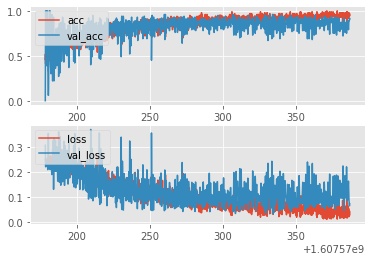


 Model observations:
 , Accuracy: 0.95  Loss: 0.0412. Val_acc: 0.91 val_loss: 0.0734


In [ ]:
create_acc_loss_graph(model_name)

#Observations
1. In-sample accuracy: This is the accuracy on the data we're actually feeding through the model for training. This is the data that we're "fitting" against.


2. Out-of-sample accuracy: This is the accuracy on data that we've set aside that the model will never see/fit against.

##**In general, we expect in-sample accuracy(training accuracy) to be higher than out-of-sample accuracy(validation accuracy).**

1. While we expect validation/out-of-sample accuracy to be a bit worse than the in-sample accuracy, we want to track that delta.

2. Something like 5-10% accuracy difference is pretty common, but as this delta grows, it usually signals to us that our model is beginning to "overfit" (the neural network is just memorizing the data and changing weights to work only for the training data, rather than generally understanding the data).

3. By tracking the out of sample loss. We will often be able to spot both losses decline to a point, and then **out of sample** loss **begins to arc** and curve back upwards. This is usually a sign that you've gotten the most out of your model's training.






